In [1]:
from keras.layers import Dense, Input, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt 
import os

Using TensorFlow backend.


In [2]:
#Reparam
# sample epsilon from N(0,1)
# z = z_mean + sqt(var) * epsilon

def sampling(args):
    # args : mean, log(Var(Q(z|X)))
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dims = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape = [batch, dims])
    return z_mean + epsilon * K.exp(0.5 * z_log_var)

In [3]:
from skimage import io 
from skimage import transform as tr
def load_data(data_dir, batch_size = 1000):
    files = os.listdir(data_dir)
    imgs = []
    ids = np.random.choice(len(files), batch_size)
    for i in ids:
        imgs.append(tr.resize(io.imread(data_dir + '/' + files[i]), [40, 40, 3]))
    return np.array(imgs)

In [4]:
#Dataset 
x_tr1 , x_tr2 = load_data('data', 1024), load_data('new_imgs', 1024)

im_size = x_tr1.shape[1]
im_depth = x_tr1.shape[3]
original_dim = im_size * im_size * im_depth
x_tr1 = np.reshape(x_tr1, [-1, original_dim])
x_tr2 = np.reshape(x_tr2, [-1, original_dim])
x_tr1 = x_tr1.astype('float32') / 256
x_tr2 = x_tr2.astype('float32') / 256

In [5]:
#network params 
input_shape = [original_dim, ]
int_dim1 = 512
int_dim2 = 128
latent_dim = 14

batch_size = 128

epoch = 200 
iters = 100

kl_coef = 0.001 / batch_size
kl_decay = kl_coef / epoch 

In [6]:
print(kl_coef)

7.8125e-06


In [7]:
# VAE Model 
#Inputs 
inp1 ,inp2 = Input(shape = input_shape, name = 'en_in1'), Input(shape = input_shape, name = 'en_in2')

#Encoder model 
x1 = Dense(int_dim1, activation = 'relu')
x2 = Dense(int_dim2, activation = 'relu')
z_mean = Dense(latent_dim, name = 'z_mean')
z_log_var = Dense(latent_dim, name = 'z_log_var')

#reparam 
z = Lambda(sampling, output_shape = [latent_dim, ], name = 'z')#([z_mean, z_log_var])

#==DOMAIN A========================================================
x2_1 = x2(x1(inp1))
z_m1 = z_mean(x2_1) # z_mean
z_l_v1 = z_log_var(x2_1) # z_log_var
zx1 = z([z_m1, z_l_v1]) # z
#==DOMAIN B========================================================
x2_2 = x2(x1(inp2))
z_m2 = z_mean(x2_2) # z_mean
z_l_v2 = z_log_var(x2_2) # z_log_var
zx2 = z([z_m2, z_l_v2]) # z
#==================================================================

#instantiate encoder models
encoder1 = Model(inp1, [z_m1, z_l_v1, zx1], name = 'enc1') # [z_mean, z_log_var, z]
encoder2 = Model(inp2, [z_m2, z_l_v2, zx2], name = 'enc2') # [z_mean, z_log_var, z]

# plot models
encoder1.summary()
plot_model(encoder1, to_file='vae__encoder1.png', show_shapes=True)

encoder2.summary()
plot_model(encoder2, to_file='vae__encoder2.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
en_in1 (InputLayer)             (None, 4800)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2458112     en_in1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          65664       dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 14)           1806        dense_2[0][0]                    
_____________________________________

In [8]:
#Decoder model 
#==========================================================
#Decoder 1 
l_inp1 = Input(shape = [latent_dim, ], name = 'z_samp1')
x2 = Dense(int_dim2, activation = 'relu')(l_inp1)
x1 = Dense(int_dim1, activation = 'relu')(x2)
outputs = Dense(original_dim, activation = 'sigmoid')(x1)

#Instantiate decoder 1
decoder1 = Model(l_inp1, outputs, name = 'decoder1')
decoder1.summary()
plot_model(decoder1, to_file='vae__decoder1.png', show_shapes=True)
#===========================================================
#Decoder 2 
l_inp2 = Input(shape = [latent_dim, ], name = 'z_samp2')
x2 = Dense(int_dim2, activation = 'relu')(l_inp2)
x1 = Dense(int_dim1, activation = 'relu')(x2)
outputs = Dense(original_dim, activation = 'sigmoid')(x1)

#Instantiate decoder 2
decoder2 = Model(l_inp2, outputs, name = 'decoder2')
decoder2.summary()
plot_model(decoder2, to_file='vae__decoder2.png', show_shapes=True)
#============================================================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_samp1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 4800)              2462400   
Total params: 2,530,368
Trainable params: 2,530,368
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_samp2 (InputLayer)         (None, 14)                0         
_________________________________________________________________


In [9]:
# VAE models 

#VAE 1
outputs1 = decoder1(encoder1(inp1)[2])
vae1 = Model(inp1, outputs1, name = 'vae1')
vae1.summary()
plot_model(vae1, to_file = 'vae1.png', show_shapes = True)

#VAE 2
outputs2 = decoder2(encoder2(inp2)[2])
vae2 = Model(inp2, outputs2, name = 'vae2')
vae2.summary()
plot_model(vae2, to_file = 'vae2.png', show_shapes = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_in1 (InputLayer)          (None, 4800)              0         
_________________________________________________________________
enc1 (Model)                 [(None, 14), (None, 14),  2527388   
_________________________________________________________________
decoder1 (Model)             (None, 4800)              2530368   
Total params: 5,057,756
Trainable params: 5,057,756
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_in2 (InputLayer)          (None, 4800)              0         
_________________________________________________________________
enc2 (Model)                 [(None, 14), (None, 14),  2527388   
_________________________________________________________________


In [10]:
#Training 

#VAE_loss = reconstruction_loss + kl_divergence
recon_loss_1 = binary_crossentropy(inp1, outputs1)
recon_loss_2 = binary_crossentropy(inp2, outputs2)
    
recon_loss_1 *= original_dim
recon_loss_2 *= original_dim

#=============== kl_1========================================
kl_loss1 = 1 + z_l_v1 - K.square(z_m1) - K.exp(z_l_v1)
kl_loss1 = K.sum(kl_loss1, axis = -1)
kl_loss1 *= -0.5
#=============== kl_2========================================
kl_loss2 = 1 + z_l_v2 - K.square(z_m2) - K.exp(z_l_v2)
kl_loss2 = K.sum(kl_loss2, axis = -1)
kl_loss2 *= -0.5
#============================================================
#for epoch in range(epochs):
    
vae1_loss = (recon_loss_1 + kl_coef * kl_loss1)
vae2_loss = (recon_loss_2 + kl_coef * kl_loss2)
    
#kl_loss -= kl_decay 
    
vae1.add_loss(vae1_loss)
vae1.compile(optimizer = 'adam')

vae2.add_loss(vae2_loss)
vae2.compile(optimizer = 'adam')

for e in range(epoch):
    print(e)
    vae1.fit(x_tr1, epochs = iters, batch_size = batch_size)
    vae1.save_weights('vae1_w.h5')
    vae2.fit(x_tr2, epochs = iters, batch_size = batch_size)
    vae2.save_weights('vae2_w.h5')
    
    x_tr1 , x_tr2 = load_data('data', 1024), load_data('new_imgs', 1024)
    x_tr1 = np.reshape(x_tr1, [-1, original_dim])
    x_tr2 = np.reshape(x_tr2, [-1, original_dim])
    x_tr1 = x_tr1.astype('float32') / 256
    x_tr2 = x_tr2.astype('float32') / 256

0
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1024/1024 [==============================] - 3s 3ms/step - loss: 2839.2104
Epoch 2/100
1024/1024 [==============================] - 0s 102us/step - loss: 941.9467
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 114.8664
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 148.5135
Epoch 5/100
1024/1024 [==============================] - 0s 99us/step - loss: 155.2161
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 130.4896
Epoch 7/100
1024/1024 [==============================] - 0s 99us/step - loss: 108.2630
Epoch 8/100
1024/1024 [==============================] - 0s 104us/step - loss: 95.7247
Epoch 9/100
1024/1024 [==============================] - 0s 99us/step - loss: 91.9153
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 90.7813
Epoch 11/100
1024/1024 [==============================] - 0s 99us/step - los

1024/1024 [==============================] - 0s 98us/step - loss: 84.0422
Epoch 92/100
1024/1024 [==============================] - 0s 99us/step - loss: 83.8927
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 83.7505
Epoch 94/100
1024/1024 [==============================] - 0s 99us/step - loss: 83.5368
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 83.4591
Epoch 96/100
1024/1024 [==============================] - 0s 99us/step - loss: 83.4608
Epoch 97/100
1024/1024 [==============================] - 0s 99us/step - loss: 83.5058
Epoch 98/100
1024/1024 [==============================] - 0s 98us/step - loss: 83.2555
Epoch 99/100
1024/1024 [==============================] - 0s 98us/step - loss: 83.2448
Epoch 100/100
1024/1024 [==============================] - 0s 97us/step - loss: 83.1429
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/step - loss: 2872.0356
Epoch 2/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 97us/step - loss: 53.0579
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0504
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0462
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0469
Epoch 88/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0395
Epoch 89/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0354
Epoch 90/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0326
Epoch 91/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0345
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0376
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0275
Epoch 94/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0258
Epoch 95/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 99us/step - loss: 81.1969
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1856
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2001
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1827
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1963
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1799
Epoch 83/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1834
Epoch 84/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1837
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1804
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1920
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1768
Epoch 88/100
1024/1024 [============================

1024/1024 [==============================] - 0s 98us/step - loss: 54.1036
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 54.1032
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 54.1026
Epoch 73/100
1024/1024 [==============================] - 0s 102us/step - loss: 54.0985
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 54.0980
Epoch 75/100
1024/1024 [==============================] - 0s 98us/step - loss: 54.0963
Epoch 76/100
1024/1024 [==============================] - 0s 98us/step - loss: 54.0939
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 54.0938
Epoch 78/100
1024/1024 [==============================] - 0s 101us/step - loss: 54.0901
Epoch 79/100
1024/1024 [==============================] - 0s 104us/step - loss: 54.0869
Epoch 80/100
1024/1024 [==============================] - 0s 103us/step - loss: 54.0867
Epoch 81/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 82.3495
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3512
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3496
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3537
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3480
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3464
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3446
Epoch 70/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3429
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3398
Epoch 72/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3361
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3378
Epoch 74/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 53.3936
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3927
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3925
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3920
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3913
Epoch 61/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3907
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3907
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3901
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3899
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3890
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3880
Epoch 67/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.9378
Epoch 50/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.9372
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9361
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9343
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9346
Epoch 54/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9356
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9338
Epoch 56/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9329
Epoch 57/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.9326
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9331
Epoch 59/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9306
Epoch 60/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 99us/step - loss: 52.7084
Epoch 43/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.7081
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7076
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7068
Epoch 46/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7065
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7062
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7060
Epoch 49/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7055
Epoch 50/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.7048
Epoch 51/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7049
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7038
Epoch 53/100
1024/1024 [============================

1024/1024 [==============================] - 0s 99us/step - loss: 82.0275
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0272
Epoch 37/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.0266
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0259
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0257
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0253
Epoch 41/100
1024/1024 [==============================] - 0s 98us/step - loss: 82.0250
Epoch 42/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0247
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0245
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0241
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0234
Epoch 46/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.8071
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8050
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8038
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8029
Epoch 32/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8015
Epoch 33/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.8000
Epoch 34/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7990
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7982
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7964
Epoch 37/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7948
Epoch 38/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7938
Epoch 39/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 98us/step - loss: 82.1668
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1660
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1652
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1642
Epoch 25/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1644
Epoch 26/100
1024/1024 [==============================] - 0s 97us/step - loss: 82.1635
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1638
Epoch 28/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.1642
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1622
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1617
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1605
Epoch 32/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 99us/step - loss: 53.2586
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2556
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2533
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2518
Epoch 18/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2503
Epoch 19/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2481
Epoch 20/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2467
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2450
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2438
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2423
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2414
Epoch 25/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.8288
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8259
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8237
Epoch 10/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8221
Epoch 11/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8201
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8189
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8175
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8164
Epoch 15/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8157
Epoch 16/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8143
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8135
Epoch 18/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 101us/step - loss: 81.7562
Epoch 1/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.9009
Epoch 2/100
1024/1024 [==============================] - 0s 116us/step - loss: 52.8371
Epoch 3/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.8106
Epoch 4/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7915
Epoch 5/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.7813
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7745
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7703
Epoch 8/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7668
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7639
Epoch 10/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7623
Epoch 11/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 99us/step - loss: 52.7056
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7050
Epoch 95/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7043
Epoch 96/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7034
Epoch 97/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.7020
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7014
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7010
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7007
7
Epoch 1/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.2269
Epoch 2/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.0383
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9626
Epoch 4/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 98us/step - loss: 81.8493
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8493
Epoch 88/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8485
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8483
Epoch 90/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8485
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8483
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8480
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8476
Epoch 94/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8479
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8472
Epoch 96/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.8469
Epoch 97/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.6128
Epoch 80/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6131
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6124
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6121
Epoch 83/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.6116
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6113
Epoch 85/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.6116
Epoch 86/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6108
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6101
Epoch 88/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6103
Epoch 89/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6092
Epoch 90/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4590
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4580
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4583
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4581
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4577
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4575
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4581
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4572
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4575
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4573
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4555
Epoch 83/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 99us/step - loss: 53.5465
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.5457
Epoch 67/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.5444
Epoch 68/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.5443
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.5441
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.5427
Epoch 71/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.5420
Epoch 72/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.5415
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.5406
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.5400
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.5394
Epoch 76/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.0918
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0914
Epoch 60/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.0912
Epoch 61/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.0912
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0923
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0912
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0910
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0909
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0903
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0901
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0902
Epoch 69/100
1024/1024 [========================

1024/1024 [==============================] - 0s 99us/step - loss: 53.3130
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3119
Epoch 53/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3108
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3096
Epoch 55/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.3087
Epoch 56/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3078
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3065
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3067
Epoch 59/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3047
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3036
Epoch 61/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3036
Epoch 62/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 101us/step - loss: 81.6006
Epoch 45/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6003
Epoch 46/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6009
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6009
Epoch 48/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6014
Epoch 49/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6004
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5993
Epoch 51/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5986
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6010
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6006
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6001
Epoch 55/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.1707
Epoch 38/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1702
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1684
Epoch 40/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1671
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1661
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1646
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1639
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1633
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1635
Epoch 46/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1629
Epoch 47/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1615
Epoch 48/100
1024/1024 [============================

1024/1024 [==============================] - 0s 104us/step - loss: 81.4594
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4591
Epoch 32/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4589
Epoch 33/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4586
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4587
Epoch 35/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4593
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4583
Epoch 37/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4576
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4572
Epoch 39/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4561
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4565
Epoch 41/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 99us/step - loss: 52.3571
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3556
Epoch 25/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3541
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3534
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3514
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3504
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3493
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3485
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3469
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3467
Epoch 33/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3453
Epoch 34/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.4438
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4431
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4416
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4409
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4412
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4404
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4394
Epoch 23/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4397
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4393
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4391
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4377
Epoch 27/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.8479
Epoch 10/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.8449
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8422
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8398
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8377
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8352
Epoch 15/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8340
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8321
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8313
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8292
Epoch 19/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.8276
Epoch 20/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 81.8719
Epoch 3/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8377
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8216
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8119
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8087
Epoch 7/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8068
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8035
Epoch 9/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8006
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7993
Epoch 11/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7982
Epoch 12/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7972
Epoch 13/100
1024/1024 [==============================] - 

1024/1024 [==============================] - 0s 100us/step - loss: 81.7766
Epoch 96/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7767
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7769
Epoch 98/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7757
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7761
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7773
Epoch 1/100
1024/1024 [==============================] - 0s 119us/step - loss: 52.8829
Epoch 2/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.6271
Epoch 3/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5248
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4763
Epoch 5/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4527
Epoch 6/100
1024/1024 [============================

1024/1024 [==============================] - 0s 99us/step - loss: 52.3235
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3237
Epoch 90/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.3230
Epoch 91/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.3226
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3218
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3207
Epoch 94/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.3202
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3193
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3190
Epoch 97/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.3177
Epoch 98/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3172
Epoch 99/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.3094
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3090
Epoch 83/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3093
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3087
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3098
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3086
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3081
Epoch 88/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3077
Epoch 89/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3082
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3072
Epoch 91/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3063
Epoch 92/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.2239
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2227
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2216
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2209
Epoch 78/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2201
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2203
Epoch 80/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2198
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2183
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2170
Epoch 83/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2169
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2156
Epoch 85/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 102us/step - loss: 81.8447
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8450
Epoch 69/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.8447
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8440
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8439
Epoch 72/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8433
Epoch 73/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8436
Epoch 74/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.8431
Epoch 75/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8436
Epoch 76/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.8434
Epoch 77/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8430
Epoch 78/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.6129
Epoch 61/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6117
Epoch 62/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6112
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6105
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6101
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6089
Epoch 66/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6087
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6078
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6068
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6057
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6044
Epoch 71/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.0104
Epoch 54/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0102
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0106
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0098
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0092
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0091
Epoch 59/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0087
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0090
Epoch 61/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0082
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0079
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0076
Epoch 64/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 51.7005
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.7003
Epoch 48/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.6991
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6978
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6966
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.6963
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6959
Epoch 53/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.6949
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6935
Epoch 55/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.6925
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6918
Epoch 57/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.8055
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8053
Epoch 41/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8052
Epoch 42/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8042
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8043
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8042
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8037
Epoch 46/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8038
Epoch 47/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8027
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8030
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8024
Epoch 50/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 53.2000
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1984
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1973
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1959
Epoch 36/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.1945
Epoch 37/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.1937
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1924
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1912
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1908
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1902
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1881
Epoch 43/100
1024/1024 [========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.4215
Epoch 26/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4205
Epoch 27/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.4195
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4189
Epoch 29/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4186
Epoch 30/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4180
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4178
Epoch 32/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4171
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4166
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4165
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4164
Epoch 36/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 105us/step - loss: 52.8068
Epoch 19/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8043
Epoch 20/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8021
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7988
Epoch 22/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7966
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7944
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7924
Epoch 25/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7906
Epoch 26/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7890
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7876
Epoch 28/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7852
Epoch 29/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.2432
Epoch 12/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.2414
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2397
Epoch 14/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2379
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2366
Epoch 16/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2360
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2348
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2338
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2330
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2323
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2316
Epoch 22/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 103us/step - loss: 52.3173
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2713
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2406
Epoch 7/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2204
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2054
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1945
Epoch 10/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.1861
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1786
Epoch 12/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1754
Epoch 13/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.1685
Epoch 14/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1643
Epoch 15/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.0403
Epoch 98/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0391
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0377
Epoch 100/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0373
20
Epoch 1/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.7587
Epoch 2/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3395
Epoch 3/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.2299
Epoch 4/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1751
Epoch 5/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.1504
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1340
Epoch 7/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1257
Epoch 8/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 99us/step - loss: 82.0753
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0749
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0748
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0752
Epoch 94/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0748
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0740
Epoch 96/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0735
Epoch 97/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0733
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.0732
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0733
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0727
Epoch 1/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 51.8575
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8564
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8555
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8543
Epoch 87/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8528
Epoch 88/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8519
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8503
Epoch 90/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8496
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8480
Epoch 92/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8465
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8456
Epoch 94/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.9449
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9443
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9435
Epoch 79/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9433
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9430
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9427
Epoch 82/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9424
Epoch 83/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9421
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9423
Epoch 85/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9418
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9418
Epoch 87/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.7075
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7059
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7049
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7035
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7018
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7009
Epoch 75/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6990
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6975
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6962
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6946
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6933
Epoch 80/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.3605
Epoch 63/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3604
Epoch 64/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3597
Epoch 65/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3588
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3585
Epoch 67/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3585
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3583
Epoch 69/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3580
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3572
Epoch 71/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3564
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3564
Epoch 73/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 102us/step - loss: 53.1490
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1475
Epoch 57/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.1451
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1432
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1419
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1399
Epoch 61/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.1382
Epoch 62/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.1365
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1351
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1332
Epoch 65/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.1312
Epoch 66/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.6973
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6972
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6968
Epoch 51/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6964
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6957
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6952
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6946
Epoch 55/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6938
Epoch 56/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6931
Epoch 57/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6929
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6926
Epoch 59/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 53.1530
Epoch 42/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.1514
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1490
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1468
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1454
Epoch 46/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.1432
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1415
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1396
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1376
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1363
Epoch 51/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1339
Epoch 52/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4685
Epoch 35/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4680
Epoch 36/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4670
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4664
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4657
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4654
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4648
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4642
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4634
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4630
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4623
Epoch 45/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.8428
Epoch 28/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8402
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8377
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8348
Epoch 31/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8326
Epoch 32/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8296
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8267
Epoch 34/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8242
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8217
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8195
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8170
Epoch 38/100
1024/1024 [======================

1024/1024 [==============================] - 0s 105us/step - loss: 81.1277
Epoch 21/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.1267
Epoch 22/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1261
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1247
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1240
Epoch 25/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1232
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1222
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1214
Epoch 28/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1210
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1202
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1191
Epoch 31/100
1024/1024 [========================

1024/1024 [==============================] - 0s 103us/step - loss: 52.4225
Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4167
Epoch 15/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4111
Epoch 16/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4060
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4014
Epoch 18/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3966
Epoch 19/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3927
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3893
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3852
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3818
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3782
Epoch 24/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4489
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4404
Epoch 8/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4357
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4321
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4288
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4265
Epoch 12/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4244
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4228
Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4212
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4197
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4182
Epoch 17/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.3690
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3682
Epoch 1/100
1024/1024 [==============================] - 0s 107us/step - loss: 53.7535
Epoch 2/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.4116
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2833
Epoch 4/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.2093
Epoch 5/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.1626
Epoch 6/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.1309
Epoch 7/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.1080
Epoch 8/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.0888
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0754
Epoch 10/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 101us/step - loss: 52.8441
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8422
Epoch 94/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8408
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8395
Epoch 96/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8384
Epoch 97/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8370
Epoch 98/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8352
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8339
Epoch 100/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8327
27
Epoch 1/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2702
Epoch 2/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9751
Epoch 3/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 101us/step - loss: 80.7396
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7394
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.7389
Epoch 88/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7384
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.7382
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.7372
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.7368
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7365
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7357
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7354
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.7352
Epoch 96/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.4283
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4265
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4250
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4236
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4220
Epoch 83/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.4205
Epoch 84/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4192
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4175
Epoch 86/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4163
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4150
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4130
Epoch 89/100
1024/1024 [========================

1024/1024 [==============================] - 0s 102us/step - loss: 81.4451
Epoch 72/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4441
Epoch 73/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4443
Epoch 74/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4433
Epoch 75/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4428
Epoch 76/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4423
Epoch 77/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4415
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4410
Epoch 79/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4406
Epoch 80/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4405
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4398
Epoch 82/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 53.0563
Epoch 65/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0548
Epoch 66/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0530
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0504
Epoch 68/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0487
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0469
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0450
Epoch 71/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0438
Epoch 72/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0420
Epoch 73/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0400
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0382
Epoch 75/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 105us/step - loss: 81.1177
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1167
Epoch 59/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1163
Epoch 60/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1153
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1148
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1150
Epoch 63/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1138
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1131
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1128
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1122
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1117
Epoch 68/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.7170
Epoch 51/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7146
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7128
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7106
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7088
Epoch 55/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7069
Epoch 56/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7051
Epoch 57/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7031
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7014
Epoch 59/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6994
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6976
Epoch 61/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.3397
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3386
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3378
Epoch 46/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3374
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3365
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3357
Epoch 49/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3349
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3340 0s - loss: 81.66
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3334
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3327
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3320
Epoch 54/100
1024/1024 [=======

1024/1024 [==============================] - 0s 100us/step - loss: 52.6298
Epoch 37/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.6274
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6250
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6229
Epoch 40/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6206
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6184
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6162
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6143
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6120
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6103
Epoch 46/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6082
Epoch 47/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 100us/step - loss: 80.8982
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8975
Epoch 31/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8966
Epoch 32/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8958
Epoch 33/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8950
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8936
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8932
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8926
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8917
Epoch 38/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.8910
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8903
Epoch 40/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.4389
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4360
Epoch 24/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4327
Epoch 25/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4294
Epoch 26/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4270
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4243
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4216
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4192
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4165
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4139
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4115
Epoch 33/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 80.9597
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9582
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9570
Epoch 18/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.9553
Epoch 19/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.9543
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9536
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9519
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9504
Epoch 23/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9498
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9479
Epoch 25/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.9468
Epoch 26/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 100us/step - loss: 53.0586
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0486
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0401
Epoch 11/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0323
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0261
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0199
Epoch 14/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0152
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0105
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0064
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0024
Epoch 18/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9986
Epoch 19/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 106us/step - loss: 82.0273
Epoch 2/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7334
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6525
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6037
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5860
Epoch 6/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5723
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5641
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5593
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5548
Epoch 10/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5513
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5487
Epoch 12/100
1024/1024 [==============================] 

1024/1024 [==============================] - 0s 100us/step - loss: 81.4761
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4757
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4752
Epoch 97/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4749
Epoch 98/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4747
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4740
Epoch 100/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4735
Epoch 1/100
1024/1024 [==============================] - 0s 116us/step - loss: 53.3642
Epoch 2/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1645
Epoch 3/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0398
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9812
Epoch 5/100
1024/1024 [============================

1024/1024 [==============================] - 0s 101us/step - loss: 52.6971
Epoch 88/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6959
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6944
Epoch 90/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6931
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6919
Epoch 92/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6909
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6896
Epoch 94/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6883
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6870
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6859
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6849
Epoch 98/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.1006
Epoch 81/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1003
Epoch 82/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0994
Epoch 83/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0988
Epoch 84/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0984
Epoch 85/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0977
Epoch 86/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0972
Epoch 87/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.0966
Epoch 88/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0958
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0953
Epoch 90/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0945
Epoch 91/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.2797
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2785
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2769
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2758
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2740
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2727
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2715
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2699
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2683
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2672
Epoch 83/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2661
Epoch 84/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.3721
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3717
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3707
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3696
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3693
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3686
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3683
Epoch 73/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3674
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3668
Epoch 75/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3664
Epoch 76/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3658
Epoch 77/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 98us/step - loss: 51.9225
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9206
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9192
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9174
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9162
Epoch 64/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9145
Epoch 65/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9133
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9116
Epoch 67/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.9100
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9085
Epoch 69/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9072
Epoch 70/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.5103
Epoch 53/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5094
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5084
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5077
Epoch 56/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5070
Epoch 57/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5059
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5052
Epoch 59/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5043
Epoch 60/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5035
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5025
Epoch 62/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5018
Epoch 63/100
1024/1024 [============================

1024/1024 [==============================] - 0s 99us/step - loss: 52.5339
Epoch 46/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5327
Epoch 47/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5310
Epoch 48/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5297
Epoch 49/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5282
Epoch 50/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5267
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5247
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5232
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5218
Epoch 54/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5204
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5196
Epoch 56/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.2292
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2288
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2281
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2270
Epoch 42/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2259
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2254
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2243
Epoch 45/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2238
Epoch 46/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2224
Epoch 47/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2218
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2210
Epoch 49/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 51.6408
Epoch 32/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6384
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6365
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6344
Epoch 35/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.6328
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6310
Epoch 37/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.6289
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6268
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6252
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6233
Epoch 41/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6215
Epoch 42/100
1024/1024 [========================

1024/1024 [==============================] - 0s 102us/step - loss: 81.2749
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2737
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2723
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2712
Epoch 28/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2699
Epoch 29/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.2692
Epoch 30/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.2680
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2668
Epoch 32/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.2658
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2647
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2637
Epoch 35/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 51.5191
Epoch 18/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.5157
Epoch 19/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.5133
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.5101
Epoch 21/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.5072
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.5044
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.5017
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.4992
Epoch 25/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.4963
Epoch 26/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.4938
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.4917
Epoch 28/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.6305
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6283
Epoch 12/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6255
Epoch 13/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6230
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6212
Epoch 15/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6197
Epoch 16/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6180
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6167
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6152
Epoch 19/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6138
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6122
Epoch 21/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 101us/step - loss: 53.1142
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0617
Epoch 5/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0354
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0187
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0061
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9972
Epoch 9/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9903
Epoch 10/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9843
Epoch 11/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9795
Epoch 12/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9752
Epoch 13/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9709
Epoch 14/100
1024/1024 [==============================] -

1024/1024 [==============================] - 0s 102us/step - loss: 52.8392
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8382
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8375
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8366
Epoch 100/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.8359
40
Epoch 1/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.2531
Epoch 2/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0573
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0019
Epoch 4/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9627
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.9421
Epoch 6/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.9294
Epoch 7/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 80.8373
Epoch 90/100
1024/1024 [==============================] - 0s 97us/step - loss: 80.8363
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8357
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8357
Epoch 93/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8351
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8345
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8340
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8332
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8325
Epoch 98/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8324
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8318
Epoch 100/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.1055
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1044
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1033
Epoch 85/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1024
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1016
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1007
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0997
Epoch 89/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0985
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0976
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0967
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0952
Epoch 93/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.1483
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1474
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1467
Epoch 78/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1463
Epoch 79/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1454
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1454
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1444
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1432
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1426
Epoch 84/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1417
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1412
Epoch 86/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.5637
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5623
Epoch 70/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5612
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5602
Epoch 72/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5591
Epoch 73/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5584
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5574
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5559
Epoch 76/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5555
Epoch 77/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.5540
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5529
Epoch 79/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 80.5392
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5382
Epoch 63/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.5378
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.5370
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.5359
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.5352
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.5343
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5340
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.5333
Epoch 70/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.5328
Epoch 71/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.5317
Epoch 72/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.5959
Epoch 55/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5942
Epoch 56/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5928
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5913
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5899
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5889
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5874
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5865
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5854
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5842
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5830
Epoch 65/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.4424
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4419
Epoch 49/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4414
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4401
Epoch 51/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4392
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4386
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4384
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4370
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4363
Epoch 56/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.4355
Epoch 57/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4350
Epoch 58/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 102us/step - loss: 52.7535
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7523
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7507
Epoch 43/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.7497
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7481
Epoch 45/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7467
Epoch 46/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7453
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7439
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7423
Epoch 49/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7408
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7394
Epoch 51/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 102us/step - loss: 81.8409
Epoch 34/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8399
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8392
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8380
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8372
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8364
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8358
Epoch 40/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8350
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8338
Epoch 42/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8329
Epoch 43/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.8320
Epoch 44/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.9024
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9005
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8987
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8976
Epoch 30/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8958
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8939
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8923
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8901
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8887
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8876
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8858
Epoch 37/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4564
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4548
Epoch 21/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4538
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4524
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4509
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4500
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4484
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4471
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4460
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4448
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4437
Epoch 30/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 52.3027
Epoch 13/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.2987
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2951
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2918
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2887
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2863
Epoch 18/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2843
Epoch 19/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2823
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2801
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2778
Epoch 22/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.2757
Epoch 23/100
1024/1024 [========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.2741
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2633
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2567
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2522
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2486
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2459
Epoch 11/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2433
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2418
Epoch 13/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2397
Epoch 14/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2383
Epoch 15/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2365
Epoch 16/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 81.1686
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1684
Epoch 100/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1677
Epoch 1/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.9306
Epoch 2/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7776
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6935
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6472
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6248
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6107
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6003
Epoch 8/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5927
Epoch 9/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 102us/step - loss: 52.4603
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4600
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4593
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4584
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4578
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4574
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4561
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4552
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4544
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4541
47
Epoch 1/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.0280
Epoch 2/100
1024/1024 [====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.6565
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6558
Epoch 86/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6551
Epoch 87/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6543
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6537
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6532
Epoch 90/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6528
Epoch 91/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6523
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6517
Epoch 93/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6510
Epoch 94/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6509
Epoch 95/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.3167
Epoch 78/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3157
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3149
Epoch 80/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.3142
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3131
Epoch 82/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3124
Epoch 83/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.3120
Epoch 84/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3110
Epoch 85/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3098
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3092
Epoch 87/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3085
Epoch 88/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.1055
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1055
Epoch 72/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1049
Epoch 73/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1046
Epoch 74/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1038
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1029
Epoch 76/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1014
Epoch 77/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1007
Epoch 78/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0998
Epoch 79/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0994
Epoch 80/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0989
Epoch 81/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 51.8534
Epoch 64/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8519
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8513
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8502
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8498
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8485
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8474
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8466
Epoch 71/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.8455
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8442
Epoch 73/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8432
Epoch 74/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 98us/step - loss: 81.1787
Epoch 57/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.1778
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1772
Epoch 59/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1765
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1756
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1746
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1739
Epoch 63/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1733
Epoch 64/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1731
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1724
Epoch 66/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1718
Epoch 67/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.8672
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8660
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8649
Epoch 52/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.8640
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8634
Epoch 54/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8625
Epoch 55/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8615
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8604
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8595
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8586
Epoch 59/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8578
Epoch 60/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 98us/step - loss: 81.5435
Epoch 43/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5427
Epoch 44/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5422
Epoch 45/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5415
Epoch 46/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5405
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5395
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5386
Epoch 49/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5378
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5368
Epoch 51/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.5366
Epoch 52/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.5355
Epoch 53/100
1024/1024 [======================

1024/1024 [==============================] - 0s 102us/step - loss: 51.6522
Epoch 36/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.6507
Epoch 37/100
1024/1024 [==============================] - 0s 107us/step - loss: 51.6502
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6492
Epoch 39/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.6477
Epoch 40/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.6456
Epoch 41/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.6443
Epoch 42/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6433
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6421
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6410
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6401
Epoch 46/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.9764
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9755
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9743
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9734
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9719
Epoch 33/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9711
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9703
Epoch 35/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9688
Epoch 36/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.9683
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9675
Epoch 38/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9663
Epoch 39/100
1024/1024 [========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.9400
Epoch 22/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.9379
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9352
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9337
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9320
Epoch 26/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9300
Epoch 27/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9282
Epoch 28/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.9263
Epoch 29/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.9246
Epoch 30/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9230
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9217
Epoch 32/100
1024/1024 [======================

1024/1024 [==============================] - 0s 99us/step - loss: 80.3801
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.3783
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.3765
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.3754
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.3739
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.3720
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.3707
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.3694
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.3685
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.3670
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.3660
Epoch 25/100
1024/1024 [========================

1024/1024 [==============================] - 0s 104us/step - loss: 52.5271
Epoch 8/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5206
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5153
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5109
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5074
Epoch 12/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5038
Epoch 13/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5006
Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4982
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4957
Epoch 16/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4932
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4905
Epoch 18/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.4044
53
Epoch 1/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6645
Epoch 2/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5426
Epoch 3/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4832
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4549
Epoch 5/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4402
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4301
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4234
Epoch 8/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4186
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4149
Epoch 10/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4121
Epoch 11/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 102us/step - loss: 81.3368
Epoch 94/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3361
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3352
Epoch 96/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3347
Epoch 97/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3341
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3340
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3330
Epoch 100/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3326
Epoch 1/100
1024/1024 [==============================] - 0s 119us/step - loss: 52.1952
Epoch 2/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.0809
Epoch 3/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0194
Epoch 4/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 51.8305
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8298
Epoch 88/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8291
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8284
Epoch 90/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8272
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.8268
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8264
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8254
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8245
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8239
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8235
Epoch 97/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.3401
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3395
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3390
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3384
Epoch 83/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3384
Epoch 84/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3374
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3367
Epoch 86/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3363
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3358
Epoch 88/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.3354
Epoch 89/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3347
Epoch 90/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.7633
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7624
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7625
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7616
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7611
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7599
Epoch 78/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7593
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7587
Epoch 80/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7578
Epoch 81/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.7573
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7567
Epoch 83/100
1024/1024 [========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.2413
Epoch 66/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2411
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2404
Epoch 68/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2395
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2387
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2384
Epoch 71/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2372
Epoch 72/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2368
Epoch 73/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2367
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2363
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2349
Epoch 76/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 106us/step - loss: 53.0690
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0690
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0678
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0672
Epoch 62/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.0659
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0647
Epoch 64/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.0636
Epoch 65/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.0629
Epoch 66/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0620
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0616
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0611
Epoch 69/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 107us/step - loss: 81.1854
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1848
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1842
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1830
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1822
Epoch 56/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1821
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1817
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1802
Epoch 59/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1795
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1791
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1779
Epoch 62/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.8944
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8936
Epoch 46/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8926
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8918
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8912
Epoch 49/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8905
Epoch 50/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8894
Epoch 51/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8885
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8874
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8864
Epoch 54/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8856
Epoch 55/100
1024/1024 [========================

1024/1024 [==============================] - 0s 102us/step - loss: 81.5434
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5426
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5427
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5413
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5404
Epoch 42/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5391
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5383
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5374
Epoch 45/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5372
Epoch 46/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5359
Epoch 47/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5352
Epoch 48/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.0010
Epoch 31/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9995
Epoch 32/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.9985
Epoch 33/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.9976
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9963
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9948
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9937
Epoch 37/100
1024/1024 [==============================] - 0s 115us/step - loss: 51.9926
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9917
Epoch 39/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9908
Epoch 40/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.9899
Epoch 41/100
1024/1024 [======================

1024/1024 [==============================] - 0s 99us/step - loss: 81.1123
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1111
Epoch 25/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1102
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1091
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1078
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1073
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1063
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1047
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1038
Epoch 32/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1027
Epoch 33/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1020
Epoch 34/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.1646
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1631
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1608
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1600
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1582
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1566
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1549
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1534
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1517
Epoch 25/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1506
Epoch 26/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.1497
Epoch 27/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 82.3701
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3671
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3646
Epoch 12/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3624
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3606
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3585
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3572
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3553
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3539
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3527
Epoch 19/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3510
Epoch 20/100
1024/1024 [======================

1024/1024 [==============================] - 0s 108us/step - loss: 52.4904
Epoch 3/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4293
Epoch 4/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4026
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3878
Epoch 6/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3762
Epoch 7/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3681
Epoch 8/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3624
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3581
Epoch 10/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3537
Epoch 11/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.3501
Epoch 12/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3472
Epoch 13/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 102us/step - loss: 52.2644
Epoch 96/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2640
Epoch 97/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2639
Epoch 98/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2628
Epoch 99/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.2620
Epoch 100/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2614
60
Epoch 1/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.1902
Epoch 2/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1080
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.0676
Epoch 4/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.0497
Epoch 5/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.0364
Epoch 6/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.9377
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9372
Epoch 90/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.9363
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9356
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9350
Epoch 93/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.9340
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9337
Epoch 95/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.9329
Epoch 96/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.9322
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9321
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9314
Epoch 99/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 52.4534
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4535
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4528
Epoch 84/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.4516
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4511
Epoch 86/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4505
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4508
Epoch 88/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4499
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4490
Epoch 90/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4482
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4480
Epoch 92/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 104us/step - loss: 81.6574
Epoch 75/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6572
Epoch 76/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6562
Epoch 77/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.6555
Epoch 78/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6550
Epoch 79/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6551
Epoch 80/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6544
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6533
Epoch 82/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6526
Epoch 83/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6518
Epoch 84/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6515
Epoch 85/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 52.4658
Epoch 68/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4650
Epoch 69/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4645
Epoch 70/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4639
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4628
Epoch 72/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4623
Epoch 73/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4620
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4614
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4615
Epoch 76/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4610
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4605
Epoch 78/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.6698
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6691
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6679
Epoch 63/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6675
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6668
Epoch 65/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6659
Epoch 66/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6653
Epoch 67/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6647
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6643
Epoch 69/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.6638
Epoch 70/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.6629
Epoch 71/100
1024/1024 [======================

1024/1024 [==============================] - 0s 98us/step - loss: 52.3506
Epoch 54/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3502
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3496
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3486
Epoch 57/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3478
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3473
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3458
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3452
Epoch 61/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3444
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3434
Epoch 63/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3425
Epoch 64/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4639
Epoch 47/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4633
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4625
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4616
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4611
Epoch 51/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.4604
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4599
Epoch 53/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4593
Epoch 54/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4582
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4575
Epoch 56/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4567
Epoch 57/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 52.6660
Epoch 40/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6644
Epoch 41/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6638
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6622
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6615
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6607
Epoch 45/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6596
Epoch 46/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6586
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6579
Epoch 48/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6570
Epoch 49/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6562
Epoch 50/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.4706
Epoch 33/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.4690
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4686
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4671
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4664
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4659
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4649
Epoch 39/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4642
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4626
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4619
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4611
Epoch 43/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 102us/step - loss: 52.4567
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4552
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4534
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4524
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4514
Epoch 30/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4508
Epoch 31/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4495
Epoch 32/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4481
Epoch 33/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4469
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4459
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4447
Epoch 36/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 80.4816
Epoch 19/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.4799
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.4785
Epoch 21/100
1024/1024 [==============================] - 0s 109us/step - loss: 80.4771
Epoch 22/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.4753
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.4741
Epoch 24/100
1024/1024 [==============================] - 0s 109us/step - loss: 80.4731
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.4719
Epoch 26/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.4707
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.4700
Epoch 28/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.4689
Epoch 29/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 52.8944
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8904
Epoch 13/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.8879
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8855
Epoch 15/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8834
Epoch 16/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.8817
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8801
Epoch 18/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8789
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8769
Epoch 20/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8759
Epoch 21/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8741
Epoch 22/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.5750
Epoch 5/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5628
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5537
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5477
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5446
Epoch 9/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.5418
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5394
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5368
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5344
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5325
Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5311
Epoch 15/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 103us/step - loss: 81.4656
Epoch 98/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4642
Epoch 99/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4635
Epoch 100/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4634
Epoch 1/100
1024/1024 [==============================] - 0s 121us/step - loss: 51.8901
Epoch 2/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.7965
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.7435
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.7206
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.7010
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6888
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.6813
Epoch 8/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 103us/step - loss: 51.5900
Epoch 91/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.5892
Epoch 92/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.5886
Epoch 93/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.5877
Epoch 94/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.5875
Epoch 95/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.5874
Epoch 96/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.5867
Epoch 97/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.5861
Epoch 98/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.5861
Epoch 99/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.5855
Epoch 100/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.58480s - loss: 51.98
67
Epoch 1/100
1024/1024 [==

1024/1024 [==============================] - 0s 103us/step - loss: 81.2903
Epoch 83/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2897
Epoch 84/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2895
Epoch 85/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2891
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2886
Epoch 87/100
1024/1024 [==============================] - 0s 115us/step - loss: 81.2881
Epoch 88/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2886
Epoch 89/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2872
Epoch 90/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2866
Epoch 91/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2857
Epoch 92/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2856
Epoch 93/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 52.5246
Epoch 76/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5236
Epoch 77/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5227
Epoch 78/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5221
Epoch 79/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5217
Epoch 80/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5214
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5208
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5205
Epoch 83/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5197
Epoch 84/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5193
Epoch 85/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5187
Epoch 86/100
1024/1024 [======================

1024/1024 [==============================] - 0s 102us/step - loss: 81.4083
Epoch 69/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.4075
Epoch 70/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4067
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4062
Epoch 72/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4054
Epoch 73/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4050
Epoch 74/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4046
Epoch 75/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4035
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4030
Epoch 77/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4024
Epoch 78/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4024
Epoch 79/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 103us/step - loss: 52.8271
Epoch 62/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8273
Epoch 63/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8263
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8254
Epoch 65/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8246
Epoch 66/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8240
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8235
Epoch 68/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8225
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8219
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8218
Epoch 71/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8208
Epoch 72/100
1024/1024 [======================

1024/1024 [==============================] - 0s 109us/step - loss: 82.1380
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1374
Epoch 56/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1366
Epoch 57/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.1359
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1354
Epoch 59/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1346
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1341
Epoch 61/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.1335
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1325
Epoch 63/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1316
Epoch 64/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1309
Epoch 65/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 102us/step - loss: 52.9725
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9717
Epoch 49/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9709
Epoch 50/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.9694
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9683
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9680
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9669
Epoch 54/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9664
Epoch 55/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.9658
Epoch 56/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.9645
Epoch 57/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.9636
Epoch 58/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.6012
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6003
Epoch 42/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5994
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5988
Epoch 44/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5980
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5975
Epoch 46/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5966
Epoch 47/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5963
Epoch 48/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.5956
Epoch 49/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5942
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5937
Epoch 51/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.7542
Epoch 34/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7528
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7520
Epoch 36/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7509
Epoch 37/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.7497
Epoch 38/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7491
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7481
Epoch 40/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7474
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7466
Epoch 42/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7457
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7451
Epoch 44/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 82.1940
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1929
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1918
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1908
Epoch 30/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1899
Epoch 31/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1891
Epoch 32/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1886
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1869
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1857
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1852
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1838
Epoch 37/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 99us/step - loss: 52.7123
Epoch 20/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7108
Epoch 21/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7092
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7074
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7066
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7053
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7046
Epoch 26/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7031
Epoch 27/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7022
Epoch 28/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7009
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7003
Epoch 30/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.3915
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3894
Epoch 14/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3873
Epoch 15/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3858
Epoch 16/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3844
Epoch 17/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3828
Epoch 18/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.3819
Epoch 19/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3802
Epoch 20/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3788
Epoch 21/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3777
Epoch 22/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3767
Epoch 23/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 103us/step - loss: 52.8112
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8027
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7970
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7915
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7880
Epoch 10/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7841
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7807
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7785
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7754
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7736
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7713
Epoch 16/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 102us/step - loss: 52.7057
Epoch 99/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7052
Epoch 100/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7059
73
Epoch 1/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6062
Epoch 2/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4616
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4209
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3971
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3850
Epoch 6/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3787
Epoch 7/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3728
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3687
Epoch 9/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 103us/step - loss: 81.2946
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2942
Epoch 93/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2934
Epoch 94/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2931
Epoch 95/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2920
Epoch 96/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2920
Epoch 97/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2908
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2901
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2898
Epoch 100/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2892
Epoch 1/100
1024/1024 [==============================] - 0s 117us/step - loss: 52.6084
Epoch 2/100
1024/1024 [========================

1024/1024 [==============================] - 0s 102us/step - loss: 52.3377
Epoch 85/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3371
Epoch 86/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.3365
Epoch 87/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3366
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3362
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3353
Epoch 90/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3347
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3348
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3342
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3337
Epoch 94/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.3332
Epoch 95/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.5734
Epoch 78/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5720
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5712
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5703
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5700
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5692
Epoch 83/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5691
Epoch 84/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5684
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5680
Epoch 86/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5674
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5664
Epoch 88/100
1024/1024 [========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.2825
Epoch 71/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.2817
Epoch 72/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2813
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2816
Epoch 74/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2803
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2797
Epoch 76/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2793
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2788
Epoch 78/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2783
Epoch 79/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.2781
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2773
Epoch 81/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.0041
Epoch 64/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0036
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0031
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0032
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0018
Epoch 68/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0009
Epoch 69/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0004
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0003
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9996
Epoch 72/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.9990
Epoch 73/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9987
Epoch 74/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 53.0964
Epoch 57/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0954
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0946
Epoch 59/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0944
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0939
Epoch 61/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.0930
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0927
Epoch 63/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.0920
Epoch 64/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.0916
Epoch 65/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0910
Epoch 66/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0902
Epoch 67/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 81.4349
Epoch 50/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4340
Epoch 51/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4333
Epoch 52/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4326
Epoch 53/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4320
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4312
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4313
Epoch 56/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4301
Epoch 57/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4294
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4285
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4283
Epoch 60/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.9110
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9100
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9088
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9082
Epoch 46/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.9073
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9061
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9053
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9050
Epoch 50/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.9052
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9048
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9034
Epoch 53/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 102us/step - loss: 81.7069
Epoch 36/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.7063
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7058
Epoch 38/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.7046
Epoch 39/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.7034
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7029
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.7026
Epoch 42/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.7019
Epoch 43/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.7009
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7000
Epoch 45/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6995
Epoch 46/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.8414
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8407
Epoch 30/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8407
Epoch 31/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8392
Epoch 32/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8382
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8374
Epoch 34/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8363
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8355
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8348
Epoch 37/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8339
Epoch 38/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.8331
Epoch 39/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 115us/step - loss: 82.3673
Epoch 22/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.36620s - loss: 83.02
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3651
Epoch 24/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.3641
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.3628
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3622
Epoch 27/100
1024/1024 [==============================] - 0s 98us/step - loss: 82.3610
Epoch 28/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3599
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.3592
Epoch 30/100
1024/1024 [==============================] - 0s 110us/step - loss: 82.3579
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.3573
Epoch 32/100
1024/1024 [========

1024/1024 [==============================] - 0s 101us/step - loss: 53.3715
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3693
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3683
Epoch 17/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.3667
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3651
Epoch 19/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.3635
Epoch 20/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.3618
Epoch 21/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.3609
Epoch 22/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.3596
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3584
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3569
Epoch 25/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.6923
Epoch 8/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6895
Epoch 9/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6862
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6841
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6816
Epoch 12/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6794
Epoch 13/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6777
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6770
Epoch 15/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6752
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6741
Epoch 17/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6727
Epoch 18/100
1024/1024 [========================

1024/1024 [==============================] - 0s 102us/step - loss: 81.6124
Epoch 1/100
1024/1024 [==============================] - 0s 122us/step - loss: 52.4112
Epoch 2/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.3330
Epoch 3/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.2823
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2583
Epoch 5/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2447
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2349
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2283
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2229
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2189
Epoch 10/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.2162
Epoch 11/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 102us/step - loss: 52.1505
Epoch 94/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1499
Epoch 95/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.1497
Epoch 96/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.1495
Epoch 97/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1488
Epoch 98/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1492
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1488
Epoch 100/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1481
80
Epoch 1/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.7602
Epoch 2/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6420
Epoch 3/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5928
Epoch 4/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 102us/step - loss: 81.4629
Epoch 87/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4630
Epoch 88/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4622
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4616
Epoch 90/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4608
Epoch 91/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4601
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4599
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4592
Epoch 94/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4589
Epoch 95/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4584
Epoch 96/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4589
Epoch 97/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 52.6894
Epoch 80/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.68930s - loss: 52.72
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6886
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6877
Epoch 83/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6876
Epoch 84/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6868
Epoch 85/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6872
Epoch 86/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6868
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6862
Epoch 88/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.6856
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6856
Epoch 90/100
1024/1024 [=====

1024/1024 [==============================] - 0s 102us/step - loss: 81.4351
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4341
Epoch 74/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4336
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4330
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4324
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4319
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4306
Epoch 79/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4304
Epoch 80/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4300
Epoch 81/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4296
Epoch 82/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4291
Epoch 83/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 102us/step - loss: 52.1319
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1315
Epoch 67/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.1311
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1307
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1303
Epoch 70/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.1294
Epoch 71/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1281
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1276
Epoch 73/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1281
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1270
Epoch 75/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.1275
Epoch 76/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.2348
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2336
Epoch 60/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.2329
Epoch 61/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2325
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2312
Epoch 63/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2308
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2301
Epoch 65/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2300
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2290
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2283
Epoch 68/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2276
Epoch 69/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 101us/step - loss: 52.6279
Epoch 52/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6267
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6264
Epoch 54/100
1024/1024 [==============================] - 0s 140us/step - loss: 52.6259
Epoch 55/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.6246
Epoch 56/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6241
Epoch 57/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6230
Epoch 58/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.6220
Epoch 59/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6212
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6205
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6200
Epoch 62/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 81.3893
Epoch 45/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3890
Epoch 46/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3879
Epoch 47/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3868
Epoch 48/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.3861
Epoch 49/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3855
Epoch 50/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3848
Epoch 51/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3839
Epoch 52/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3829
Epoch 53/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.3822
Epoch 54/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.3816
Epoch 55/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 52.5686
Epoch 38/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5676
Epoch 39/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5665
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5663
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5658
Epoch 42/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.5647
Epoch 43/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5637
Epoch 44/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5628
Epoch 45/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5621
Epoch 46/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5615
Epoch 47/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5607
Epoch 48/100
1024/1024 [======================

1024/1024 [==============================] - 0s 101us/step - loss: 81.7989
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7977
Epoch 32/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7968
Epoch 33/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7960
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7952
Epoch 35/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7941
Epoch 36/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.7930
Epoch 37/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7926
Epoch 38/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7915
Epoch 39/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7913
Epoch 40/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.7907
Epoch 41/100
1024/1024 [==============================

Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9282
Epoch 25/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9273
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9260
Epoch 27/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.9256
Epoch 28/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9246
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9242
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9233
Epoch 31/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9218
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9211
Epoch 33/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9196
Epoch 34/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.9194
Epoch 35/100
1024/1024 [================

1024/1024 [==============================] - 0s 100us/step - loss: 80.8686
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8672
Epoch 19/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8656
Epoch 20/100
1024/1024 [==============================] - 0s 97us/step - loss: 80.8649
Epoch 21/100
1024/1024 [==============================] - 0s 96us/step - loss: 80.8633
Epoch 22/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.8620
Epoch 23/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8610
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8596
Epoch 25/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8584
Epoch 26/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.8573
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8569
Epoch 28/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.5362
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5337
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5314
Epoch 13/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5297
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5274
Epoch 15/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5257
Epoch 16/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5238
Epoch 17/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5224
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5211
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5192
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5179
Epoch 21/100
1024/1024 [========================

1024/1024 [==============================] - 0s 103us/step - loss: 81.7057
Epoch 4/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6762
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6636
Epoch 6/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.6529
Epoch 7/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6459
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6415
Epoch 9/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6379
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6344
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6320
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6301
Epoch 13/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6280
Epoch 14/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 101us/step - loss: 81.5615
Epoch 97/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5612
Epoch 98/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5607
Epoch 99/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5602
Epoch 100/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5599
Epoch 1/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7894
Epoch 2/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6993
Epoch 3/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6587
Epoch 4/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6308
Epoch 5/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6151
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6062
Epoch 7/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.5250
Epoch 90/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5245
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5246
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5246
Epoch 93/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5238
Epoch 94/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5233
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5234
Epoch 96/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5226
Epoch 97/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5219
Epoch 98/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5212
Epoch 99/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5211
Epoch 100/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4242
Epoch 83/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4238
Epoch 84/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4240
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4230
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4225
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4220
Epoch 88/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4220
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4230
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4213
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4202
Epoch 92/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4193
Epoch 93/100
1024/1024 [============================

1024/1024 [==============================] - 0s 99us/step - loss: 52.7359
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7348
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7346
Epoch 78/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7337
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7332
Epoch 80/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7330
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7324
Epoch 82/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.7319
Epoch 83/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7324
Epoch 84/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7317
Epoch 85/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7308
Epoch 86/100
1024/1024 [============================

1024/1024 [==============================] - 0s 98us/step - loss: 81.0804
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0800
Epoch 70/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0796
Epoch 71/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.0793
Epoch 72/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0785
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0781
Epoch 74/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.0771
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0760
Epoch 76/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.0753
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0746
Epoch 78/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0740
Epoch 79/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.6756
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6750
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6748
Epoch 64/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6739
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6735
Epoch 66/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.6728
Epoch 67/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6724
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6721
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6716
Epoch 70/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6711
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6703
Epoch 72/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.6029
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6024
Epoch 56/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6017
Epoch 57/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6010
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5999
Epoch 59/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5999
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5993
Epoch 61/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5984
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5978
Epoch 63/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.5978
Epoch 64/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.5966
Epoch 65/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.2579
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2569
Epoch 49/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2561
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2551
Epoch 51/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.2547
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2539
Epoch 53/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2538
Epoch 54/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2528
Epoch 55/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2524
Epoch 56/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2519
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2511
Epoch 58/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 99us/step - loss: 81.4283
Epoch 41/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4277
Epoch 42/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4267
Epoch 43/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4257
Epoch 44/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4253
Epoch 45/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4245
Epoch 46/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4235
Epoch 47/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.4225
Epoch 48/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4217
Epoch 49/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4212
Epoch 50/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4204
Epoch 51/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.3410
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3401
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3394
Epoch 36/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.3384
Epoch 37/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3372
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3370
Epoch 39/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.3366
Epoch 40/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3362
Epoch 41/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3355
Epoch 42/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3341
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3338
Epoch 44/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 80.9212
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.9199
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9194
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9181
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9171
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9160
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9151
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.9144
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9136
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9126
Epoch 36/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9118
Epoch 37/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 53.4687
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.4670
Epoch 21/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.4652
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.4639
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.4629
Epoch 24/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.4629
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.4613
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.4601
Epoch 27/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.4593
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.4579
Epoch 29/100
1024/1024 [==============================] - 0s 97us/step - loss: 53.4563
Epoch 30/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.7460
Epoch 13/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7436
Epoch 14/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7423
Epoch 15/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7407
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7388
Epoch 17/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7378
Epoch 18/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.7367
Epoch 19/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7355
Epoch 20/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7341
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7327
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7314
Epoch 23/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 99us/step - loss: 52.7467
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7364
Epoch 7/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.7300
Epoch 8/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.7252
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7205
Epoch 10/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7172
Epoch 11/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.7133
Epoch 12/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7100
Epoch 13/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7075
Epoch 14/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7055
Epoch 15/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7030
Epoch 16/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.6468
Epoch 99/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6467
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6460
93
Epoch 1/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.3230
Epoch 2/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2286
Epoch 3/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1930
Epoch 4/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1715
Epoch 5/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1619
Epoch 6/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1546
Epoch 7/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1501
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1469
Epoch 9/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 81.0740
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0731
Epoch 93/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0727
Epoch 94/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0722
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0722
Epoch 96/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0719
Epoch 97/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.0718
Epoch 98/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0707
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0704
Epoch 100/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0697
Epoch 1/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.6040
Epoch 2/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 51.3455
Epoch 85/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.3448
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.3442
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.3445
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.3444
Epoch 89/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.3438
Epoch 90/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.3424
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.3418
Epoch 92/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.3415
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.3412
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.3408
Epoch 95/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.2201
Epoch 78/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2192
Epoch 79/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2185
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2179
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2181
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.2177
Epoch 83/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2176
Epoch 84/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2170
Epoch 85/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2155
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2153
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2144
Epoch 88/100
1024/1024 [============================

1024/1024 [==============================] - 0s 102us/step - loss: 52.2260
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2248
Epoch 72/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2243
Epoch 73/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2234
Epoch 74/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2230
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2225
Epoch 76/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2217
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2212
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2205
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2204
Epoch 80/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2202
Epoch 81/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.4426
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4421
Epoch 65/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4414
Epoch 66/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4415
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4404
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4397
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4393
Epoch 70/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4388
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4381
Epoch 72/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4373
Epoch 73/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4371
Epoch 74/100
1024/1024 [==============================

Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0032
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0028
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0021
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0018
Epoch 61/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0011
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0007
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9999
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9991
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9992
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9985
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9979
Epoch 68/100
1024/1024 [================

1024/1024 [==============================] - 0s 100us/step - loss: 81.5542
Epoch 51/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5537
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5529
Epoch 53/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5520
Epoch 54/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5512
Epoch 55/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5505
Epoch 56/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5503
Epoch 57/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5493
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5491
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5481
Epoch 60/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5475
Epoch 61/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.0005
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9999
Epoch 46/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9988
Epoch 47/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9981
Epoch 48/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9974
Epoch 49/100
1024/1024 [==============================] - 0s 96us/step - loss: 51.9973
Epoch 50/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9969
Epoch 51/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9966
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9958
Epoch 53/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9952
Epoch 54/100
1024/1024 [==============================] - 0s 96us/step - loss: 51.9951
Epoch 55/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 104us/step - loss: 81.2466
Epoch 38/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2464
Epoch 39/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2452
Epoch 40/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2447
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2437
Epoch 42/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2430
Epoch 43/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2427
Epoch 44/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2415
Epoch 45/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2414
Epoch 46/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2400
Epoch 47/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.2388
Epoch 48/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 53.1529
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1520
Epoch 32/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1512
Epoch 33/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.1506
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1499
Epoch 35/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.1488
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1477
Epoch 37/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.1473
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1466
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1462
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1450
Epoch 41/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 82.0886
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0874
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0866
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0855
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0845
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0836
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0828
Epoch 30/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.0821
Epoch 31/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.0808
Epoch 32/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.0799
Epoch 33/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.0789
Epoch 34/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 98us/step - loss: 53.3752
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3738
Epoch 18/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.3722
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3709
Epoch 20/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.3702
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3696
Epoch 22/100
1024/1024 [==============================] - 0s 97us/step - loss: 53.3685
Epoch 23/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.3681
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3671
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3661
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.3643
Epoch 27/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 80.8319
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8285
Epoch 11/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.8259
Epoch 12/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.8242
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8219
Epoch 14/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.8197
Epoch 15/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8184
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.8162
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.8144
Epoch 18/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8130
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.8110
Epoch 20/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 103us/step - loss: 52.9088
Epoch 3/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8719
Epoch 4/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.8497
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8349
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8258
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8178
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8127
Epoch 9/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8084
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8055
Epoch 11/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8027
Epoch 12/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7995
Epoch 13/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 99us/step - loss: 52.7374
Epoch 96/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7374
Epoch 97/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.7374
Epoch 98/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.7367
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7363
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7356
100
Epoch 1/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3304
Epoch 2/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2494
Epoch 3/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2149
Epoch 4/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1934
Epoch 5/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1847
Epoch 6/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 99us/step - loss: 81.1003
Epoch 89/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0998
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0994
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0992
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0986
Epoch 93/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.0991
Epoch 94/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.0978
Epoch 95/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0965
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0961
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0956
Epoch 98/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.0951
Epoch 99/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.3019
Epoch 82/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3019
Epoch 83/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3010
Epoch 84/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3010
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3016
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3012
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3004
Epoch 88/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2997
Epoch 89/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2993
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2995
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2984
Epoch 92/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 80.7261
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7250
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.7247
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7241
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7235
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.7233
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7230
Epoch 81/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.7220
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.7211
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7208
Epoch 84/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7200
Epoch 85/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.4826
Epoch 68/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4824
Epoch 69/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4816
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4811
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4810
Epoch 72/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4806
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4805
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4802
Epoch 75/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4796
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4793
Epoch 77/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4792
Epoch 78/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.8786
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8782
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8777
Epoch 63/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8764
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8754
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8745
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8740
Epoch 67/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.8739
Epoch 68/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.8731
Epoch 69/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.8721
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8715
Epoch 71/100
1024/1024 [=============================

Epoch 54/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8566
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8558
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8549
Epoch 57/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8547
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8543
Epoch 59/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8536
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8529
Epoch 61/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8526
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8519
Epoch 63/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8517
Epoch 64/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8509
Epoch 65/100
1024/1024 [============

1024/1024 [==============================] - 0s 101us/step - loss: 82.1246
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1238
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1232
Epoch 50/100
1024/1024 [==============================] - 0s 97us/step - loss: 82.1224
Epoch 51/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1219
Epoch 52/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1213
Epoch 53/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1206
Epoch 54/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1206
Epoch 55/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1193
Epoch 56/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1185
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1176
Epoch 58/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.0793
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0781
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0774
Epoch 43/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.0771
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0760
Epoch 45/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0759
Epoch 46/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0749
Epoch 47/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0746
Epoch 48/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0735
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0731
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0727
Epoch 51/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.1024
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1018
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1012
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0999
Epoch 37/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.0987
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0983
Epoch 39/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0974
Epoch 40/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0966
Epoch 41/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0958
Epoch 42/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0950
Epoch 43/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0941
Epoch 44/100
1024/1024 [============================

1024/1024 [==============================] - 0s 99us/step - loss: 53.0751
Epoch 27/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0747
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0744
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0732
Epoch 30/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0720
Epoch 31/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0711
Epoch 32/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0701
Epoch 33/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0697
Epoch 34/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0686
Epoch 35/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0676
Epoch 36/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0666
Epoch 37/100
1024/1024 [============================

1024/1024 [==============================] - 0s 101us/step - loss: 81.6892
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6883
Epoch 21/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6875
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6864
Epoch 23/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6851
Epoch 24/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6838
Epoch 25/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.6830
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6815
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6805
Epoch 28/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6795
Epoch 29/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6787
Epoch 30/100
1024/1024 [============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.2357
Epoch 13/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.2333
Epoch 14/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2307
Epoch 15/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2289
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2274
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2260
Epoch 18/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2242
Epoch 19/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2231
Epoch 20/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2219
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2208
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2195
Epoch 23/100
1024/1024 [========================

1024/1024 [==============================] - 0s 99us/step - loss: 81.3829
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3772
Epoch 7/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3723
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3692
Epoch 9/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3660
Epoch 10/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3633
Epoch 11/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3610
Epoch 12/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3591
Epoch 13/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3575
Epoch 14/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3561
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3548
Epoch 16/100
1024/1024 [============================

1024/1024 [==============================] - 0s 99us/step - loss: 81.3022
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3021
Epoch 100/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.3021
Epoch 1/100
1024/1024 [==============================] - 0s 122us/step - loss: 52.1141
Epoch 2/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.0568
Epoch 3/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0162
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.9923
Epoch 5/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9777
Epoch 6/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.9683
Epoch 7/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.9610
Epoch 8/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.9569
Epoch 9/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 98us/step - loss: 51.8889
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8887
Epoch 93/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8889
Epoch 94/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.8881
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8875
Epoch 96/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8873
Epoch 97/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8869
Epoch 98/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.8863
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.8856
Epoch 100/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8851
107
Epoch 1/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1937
Epoch 2/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 99us/step - loss: 80.9475
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9469
Epoch 86/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9463
Epoch 87/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.9460
Epoch 88/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9450
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9446
Epoch 90/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9445
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.9440
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9432
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.9421
Epoch 94/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9417
Epoch 95/100
1024/1024 [========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.6544
Epoch 78/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6540
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6538
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6534
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6532
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6530
Epoch 83/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6523
Epoch 84/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6520
Epoch 85/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6515
Epoch 86/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6510
Epoch 87/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6512
Epoch 88/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 99us/step - loss: 80.5790
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5784
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.5778
Epoch 73/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5777
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5773
Epoch 75/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5759
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5757
Epoch 77/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.5752
Epoch 78/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5743
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5733
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.5731
Epoch 81/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 98us/step - loss: 51.6416
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.6406
Epoch 65/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.6402
Epoch 66/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.6395
Epoch 67/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.6390
Epoch 68/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.6386
Epoch 69/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6380
Epoch 70/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.6376
Epoch 71/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.6370
Epoch 72/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.6366
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.6363
Epoch 74/100
1024/1024 [========================

1024/1024 [==============================] - 0s 98us/step - loss: 81.3248
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3243
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3237
Epoch 59/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3236
Epoch 60/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3227
Epoch 61/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.3219
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3214
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3206
Epoch 64/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3201
Epoch 65/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3191
Epoch 66/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3185
Epoch 67/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.2189
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2183
Epoch 51/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2178
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2174
Epoch 53/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2167
Epoch 54/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2159
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2156
Epoch 56/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.2155
Epoch 57/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.2150
Epoch 58/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.2148
Epoch 59/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2143
Epoch 60/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 82.1008
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1000
Epoch 44/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0993
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0982
Epoch 46/100
1024/1024 [==============================] - 0s 97us/step - loss: 82.0974
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0965
Epoch 48/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0958
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0952
Epoch 50/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.0944
Epoch 51/100
1024/1024 [==============================] - 0s 97us/step - loss: 82.0936
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0930
Epoch 53/100
1024/1024 [============================

1024/1024 [==============================] - 0s 98us/step - loss: 52.3853
Epoch 37/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3842
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3834
Epoch 39/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3834
Epoch 40/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3824
Epoch 41/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.3817
Epoch 42/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.3808
Epoch 43/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3801
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3796
Epoch 45/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.3791
Epoch 46/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3788
Epoch 47/100
1024/1024 [============================

Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5615
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5603
Epoch 32/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5594
Epoch 33/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5587
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5578
Epoch 35/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5571
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5564
Epoch 37/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5552
Epoch 38/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5546
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5541
Epoch 40/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5535
Epoch 41/100
1024/1024 [================

1024/1024 [==============================] - 0s 100us/step - loss: 52.6244
Epoch 24/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6228
Epoch 25/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.6212
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6207
Epoch 27/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.6194
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6187
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6176
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6170
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6158
Epoch 32/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6146
Epoch 33/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6140
Epoch 34/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 98us/step - loss: 81.1235
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1224
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1207
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1197
Epoch 20/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1187
Epoch 21/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1175
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1161
Epoch 23/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1151
Epoch 24/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.1145
Epoch 25/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1142
Epoch 26/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1133
Epoch 27/100
1024/1024 [=============================

Epoch 10/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.4521
Epoch 11/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4494
Epoch 12/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4474
Epoch 13/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4458
Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4434
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4416
Epoch 16/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4410
Epoch 17/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.4392
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4380
Epoch 19/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4367
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4350
Epoch 21/100
1024/1024 [===============

1024/1024 [==============================] - 0s 100us/step - loss: 81.5820
Epoch 4/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5633
Epoch 5/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5520
Epoch 6/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5466
Epoch 7/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5414
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5379
Epoch 9/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5349
Epoch 10/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5327
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5304
Epoch 12/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5281
Epoch 13/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5265
Epoch 14/100
1024/1024 [==============================] 

1024/1024 [==============================] - 0s 99us/step - loss: 81.4624
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4617
Epoch 98/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4612
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4609
Epoch 100/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4602
Epoch 1/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.7627
Epoch 2/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7053
Epoch 3/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6751
Epoch 4/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6558
Epoch 5/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6439
Epoch 6/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6366
Epoch 7/100
1024/1024 [==============================] -

1024/1024 [==============================] - 0s 98us/step - loss: 52.5689
Epoch 90/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5680
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5675
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5676
Epoch 93/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5671
Epoch 94/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5662
Epoch 95/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5664
Epoch 96/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5663
Epoch 97/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5659
Epoch 98/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5661
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5653
Epoch 100/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 81.5208
Epoch 83/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5208
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5202
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5196
Epoch 86/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5194
Epoch 87/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5188
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.5182
Epoch 89/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5176
Epoch 90/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5173
Epoch 91/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5173
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5163
Epoch 93/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 101us/step - loss: 52.4891
Epoch 76/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4884
Epoch 77/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4884
Epoch 78/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4879
Epoch 79/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4876
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4870
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4866
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4864
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4858
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4862
Epoch 85/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4853
Epoch 86/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 101us/step - loss: 81.6080
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6068
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6062
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6056
Epoch 72/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.6052
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6057
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6042
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6036
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6024
Epoch 77/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6017
Epoch 78/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.6018
Epoch 79/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.1701
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1693
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1690
Epoch 64/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1684
Epoch 65/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1684
Epoch 66/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.1683
Epoch 67/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1679
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1671
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1667
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1665
Epoch 71/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1661
Epoch 72/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 99us/step - loss: 81.4201
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4192
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4188
Epoch 57/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4192
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4178
Epoch 59/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4178
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4168
Epoch 61/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4159
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4151
Epoch 63/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4144
Epoch 64/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4138
Epoch 65/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 100us/step - loss: 52.1550
Epoch 48/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.1548
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1542
Epoch 50/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.1533
Epoch 51/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.1528
Epoch 52/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.1521
Epoch 53/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.1514
Epoch 54/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.1514
Epoch 55/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.1508
Epoch 56/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1505
Epoch 57/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1499
Epoch 58/100
1024/1024 [========================

1024/1024 [==============================] - 0s 102us/step - loss: 80.9875
Epoch 41/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.9864
Epoch 42/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9857
Epoch 43/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9852
Epoch 44/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.9843
Epoch 45/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9836
Epoch 46/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9829
Epoch 47/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9817
Epoch 48/100
1024/1024 [==============================] - 0s 109us/step - loss: 80.9808
Epoch 49/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9802
Epoch 50/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9797
Epoch 51/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 52.8758
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8751
Epoch 35/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8742
Epoch 36/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8739
Epoch 37/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.8732
Epoch 38/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8726
Epoch 39/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8726
Epoch 40/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8716
Epoch 41/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8707
Epoch 42/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8702
Epoch 43/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8695
Epoch 44/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 94us/step - loss: 81.7456
Epoch 27/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.7445
Epoch 28/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.7435
Epoch 29/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.7424
Epoch 30/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.7419
Epoch 31/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.7411
Epoch 32/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.7400
Epoch 33/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.7388
Epoch 34/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.7381
Epoch 35/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.7377
Epoch 36/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.7364
Epoch 37/100
1024/1024 [==============================] 

1024/1024 [==============================] - 0s 101us/step - loss: 52.4462
Epoch 21/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4454
Epoch 22/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4439
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4428
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4416
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4400
Epoch 26/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4393
Epoch 27/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.4378
Epoch 28/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.4370
Epoch 29/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4366
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4358
Epoch 31/100
1024/1024 [========================

Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2962
Epoch 15/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2949
Epoch 16/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2935
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2920
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2907
Epoch 19/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2896
Epoch 20/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2883
Epoch 21/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.2877
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2871
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2856
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2845
Epoch 25/100
1024/1024 [=============

1024/1024 [==============================] - 0s 109us/step - loss: 52.5831
Epoch 8/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.5801
Epoch 9/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5764
Epoch 10/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5751
Epoch 11/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.5710
Epoch 12/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5673
Epoch 13/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5656
Epoch 14/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.5627
Epoch 15/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.5612
Epoch 16/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.5597
Epoch 17/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.5579
Epoch 18/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 97us/step - loss: 52.5147
120
Epoch 1/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6656
Epoch 2/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.5961
Epoch 3/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.5631
Epoch 4/100
1024/1024 [==============================] - 0s 117us/step - loss: 81.5462
Epoch 5/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.5373
Epoch 6/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.5300
Epoch 7/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.5246
Epoch 8/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5211
Epoch 9/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.5181
Epoch 10/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5153
Epoch 11/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 120us/step - loss: 81.4539
Epoch 94/100
1024/1024 [==============================] - 0s 121us/step - loss: 81.4533
Epoch 95/100
1024/1024 [==============================] - 0s 117us/step - loss: 81.4529
Epoch 96/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.4527
Epoch 97/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.4523
Epoch 98/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.4518
Epoch 99/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.4513
Epoch 100/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.4512
Epoch 1/100
1024/1024 [==============================] - 0s 116us/step - loss: 52.4376
Epoch 2/100
1024/1024 [==============================] - 0s 118us/step - loss: 52.3868
Epoch 3/100
1024/1024 [==============================] - 0s 117us/step - loss: 52.3588
Epoch 4/100
1024/1024 [========================

1024/1024 [==============================] - 0s 100us/step - loss: 52.2659
Epoch 87/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2658
Epoch 88/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2656
Epoch 89/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2651
Epoch 90/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.2645
Epoch 91/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2636
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2637
Epoch 93/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2632
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.2632
Epoch 95/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2632
Epoch 96/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.2621
Epoch 97/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 99us/step - loss: 81.9371
Epoch 80/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9363
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9358
Epoch 82/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9355
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9353
Epoch 84/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9350
Epoch 85/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9340
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9336
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9329
Epoch 88/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9320
Epoch 89/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.9316
Epoch 90/100
1024/1024 [==============================

Epoch 73/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0367
Epoch 74/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0365
Epoch 75/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.0361
Epoch 76/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0360
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0362
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0352
Epoch 79/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0344
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0337
Epoch 81/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.0337
Epoch 82/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0335
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.0325
Epoch 84/100
1024/1024 [=================

1024/1024 [==============================] - 0s 98us/step - loss: 80.8926
Epoch 67/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8921
Epoch 68/100
1024/1024 [==============================] - 0s 107us/step - loss: 80.8917
Epoch 69/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8909
Epoch 70/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8900
Epoch 71/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8895
Epoch 72/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8891
Epoch 73/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8889
Epoch 74/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.8881
Epoch 75/100
1024/1024 [==============================] - 0s 97us/step - loss: 80.8882
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.8881
Epoch 77/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 102us/step - loss: 52.6757
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6751
Epoch 61/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6748
Epoch 62/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.6744
Epoch 63/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6738
Epoch 64/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6739
Epoch 65/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6738
Epoch 66/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6732
Epoch 67/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6725
Epoch 68/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6717
Epoch 69/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6709
Epoch 70/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 80.6658
Epoch 53/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.6654
Epoch 54/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.6647
Epoch 55/100
1024/1024 [==============================] - 0s 100us/step - loss: 80.6642
Epoch 56/100
1024/1024 [==============================] - 0s 97us/step - loss: 80.6637
Epoch 57/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.6635
Epoch 58/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.6625
Epoch 59/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.6619
Epoch 60/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.6611
Epoch 61/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.6606
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.6602
Epoch 63/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 98us/step - loss: 52.9333
Epoch 47/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.9320
Epoch 48/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9318
Epoch 49/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.9311
Epoch 50/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.9306
Epoch 51/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9299
Epoch 52/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9298
Epoch 53/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9291
Epoch 54/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.9284
Epoch 55/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.9277
Epoch 56/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.9276
Epoch 57/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 101us/step - loss: 81.4859
Epoch 40/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4850
Epoch 41/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4843
Epoch 42/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4840
Epoch 43/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4839
Epoch 44/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4827
Epoch 45/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4820
Epoch 46/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4809
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4805
Epoch 48/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4799
Epoch 49/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.4789
Epoch 50/100
1024/1024 [======================

1024/1024 [==============================] - 0s 102us/step - loss: 52.8210
Epoch 33/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8208
Epoch 34/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8197
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8190
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8186
Epoch 37/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8180
Epoch 38/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8171
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8158
Epoch 40/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8152
Epoch 41/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8144
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8143
Epoch 43/100
1024/1024 [==========================

Epoch 26/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.3999
Epoch 27/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.3993
Epoch 28/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3986
Epoch 29/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.3980
Epoch 30/100
1024/1024 [==============================] - 0s 121us/step - loss: 81.3974
Epoch 31/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.3968
Epoch 32/100
1024/1024 [==============================] - 0s 117us/step - loss: 81.3958
Epoch 33/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.3948
Epoch 34/100
1024/1024 [==============================] - 0s 117us/step - loss: 81.3939
Epoch 35/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.3931
Epoch 36/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.3928
Epoch 37/100
1024/1024 [========

1024/1024 [==============================] - 0s 103us/step - loss: 53.0486
Epoch 20/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.0473
Epoch 21/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.0468
Epoch 22/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.0451
Epoch 23/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.0446
Epoch 24/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0441
Epoch 25/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.0431
Epoch 26/100
1024/1024 [==============================] - 0s 106us/step - loss: 53.0425
Epoch 27/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0413
Epoch 28/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0406
Epoch 29/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0397
Epoch 30/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 100us/step - loss: 81.1122
Epoch 13/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1101
Epoch 14/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1087
Epoch 15/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1074
Epoch 16/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1059
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1050
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1040
Epoch 19/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1030
Epoch 20/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1014
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1008
Epoch 22/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0996
Epoch 23/100
1024/1024 [========================

1024/1024 [==============================] - 0s 120us/step - loss: 53.2555
Epoch 6/100
1024/1024 [==============================] - 0s 119us/step - loss: 53.2477
Epoch 7/100
1024/1024 [==============================] - 0s 118us/step - loss: 53.2417
Epoch 8/100
1024/1024 [==============================] - 0s 116us/step - loss: 53.2372
Epoch 9/100
1024/1024 [==============================] - 0s 116us/step - loss: 53.2337
Epoch 10/100
1024/1024 [==============================] - 0s 118us/step - loss: 53.2314
Epoch 11/100
1024/1024 [==============================] - 0s 120us/step - loss: 53.2292
Epoch 12/100
1024/1024 [==============================] - 0s 119us/step - loss: 53.2279
Epoch 13/100
1024/1024 [==============================] - 0s 117us/step - loss: 53.2252
Epoch 14/100
1024/1024 [==============================] - 0s 120us/step - loss: 53.2235
Epoch 15/100
1024/1024 [==============================] - 0s 115us/step - loss: 53.2226
Epoch 16/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 99us/step - loss: 53.1748
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1746
Epoch 100/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1746
127
Epoch 1/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1773
Epoch 2/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1103
Epoch 3/100
1024/1024 [==============================] - 0s 107us/step - loss: 82.0765
Epoch 4/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.0601
Epoch 5/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0522
Epoch 6/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.0462
Epoch 7/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0418
Epoch 8/100
1024/1024 [==============================] - 0s 97us/step - loss: 82.0387
Epoch 9/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 98us/step - loss: 81.9754
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9748
Epoch 94/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9747
Epoch 95/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9742
Epoch 96/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9736
Epoch 97/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9731
Epoch 98/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.9729
Epoch 99/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9724
Epoch 100/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.9720
Epoch 1/100
1024/1024 [==============================] - 0s 119us/step - loss: 52.0908
Epoch 2/100
1024/1024 [==============================] - 0s 117us/step - loss: 52.0386
Epoch 3/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 99us/step - loss: 51.8966
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8968
Epoch 88/100
1024/1024 [==============================] - 0s 97us/step - loss: 51.8964
Epoch 89/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.8959
Epoch 90/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.8947
Epoch 91/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8944
Epoch 92/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8940
Epoch 93/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.8943
Epoch 94/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.8935
Epoch 95/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8938
Epoch 96/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.8934
Epoch 97/100
1024/1024 [==============================] 

1024/1024 [==============================] - 0s 103us/step - loss: 81.7550
Epoch 80/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.7545
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.7538
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7529
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7527
Epoch 84/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7523
Epoch 85/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.7517
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7519
Epoch 87/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.7511
Epoch 88/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.7504
Epoch 89/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.7496
Epoch 90/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 53.2829
Epoch 73/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.2823
Epoch 74/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.2819
Epoch 75/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2811
Epoch 76/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2812
Epoch 77/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.2808
Epoch 78/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.2806
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2801
Epoch 80/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2802
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2798
Epoch 82/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2797
Epoch 83/100
1024/1024 [======================

1024/1024 [==============================] - 0s 99us/step - loss: 81.8970
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8965
Epoch 67/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8962
Epoch 68/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8956
Epoch 69/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8953
Epoch 70/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8946
Epoch 71/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8940
Epoch 72/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8934
Epoch 73/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8930
Epoch 74/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.8930
Epoch 75/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.8924
Epoch 76/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 101us/step - loss: 52.4512
Epoch 59/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4508
Epoch 60/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4502
Epoch 61/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4498
Epoch 62/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4490
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4491
Epoch 64/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4485
Epoch 65/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4483
Epoch 66/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4479
Epoch 67/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4474
Epoch 68/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4466
Epoch 69/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 107us/step - loss: 81.5861
Epoch 52/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.5855
Epoch 53/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.5851
Epoch 54/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.5843
Epoch 55/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5836
Epoch 56/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.5832
Epoch 57/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.5826
Epoch 58/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.5825
Epoch 59/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.5819
Epoch 60/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.5814
Epoch 61/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5811
Epoch 62/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 101us/step - loss: 52.6243
Epoch 45/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6238
Epoch 46/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6228
Epoch 47/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6220
Epoch 48/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6215
Epoch 49/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6207
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6202
Epoch 51/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6200
Epoch 52/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6199
Epoch 53/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6193
Epoch 54/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6192
Epoch 55/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 106us/step - loss: 81.3243
Epoch 38/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3236
Epoch 39/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3226
Epoch 40/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3217
Epoch 41/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.3215
Epoch 42/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.3207
Epoch 43/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3199
Epoch 44/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3194
Epoch 45/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3188
Epoch 46/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3179
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3168
Epoch 48/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 53.0655
Epoch 31/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.0644
Epoch 32/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0633
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0629
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.0624
Epoch 35/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.0616
Epoch 36/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0613
Epoch 37/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.0609
Epoch 38/100
1024/1024 [==============================] - 0s 107us/step - loss: 53.0605
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0594
Epoch 40/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.0587
Epoch 41/100
1024/1024 [========================

1024/1024 [==============================] - 0s 106us/step - loss: 81.3881
Epoch 24/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3871
Epoch 25/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3858
Epoch 26/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3847
Epoch 27/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3839
Epoch 28/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3830
Epoch 29/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3822
Epoch 30/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3812
Epoch 31/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3798
Epoch 32/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3793
Epoch 33/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.3781
Epoch 34/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 101us/step - loss: 52.7982
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7962
Epoch 18/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7947
Epoch 19/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7942
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7930
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7919
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7911
Epoch 23/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7901
Epoch 24/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7887
Epoch 25/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.7885
Epoch 26/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7873
Epoch 27/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 108us/step - loss: 81.3158
Epoch 10/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.3137
Epoch 11/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3113
Epoch 12/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.3096
Epoch 13/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.3086
Epoch 14/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3073
Epoch 15/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3063
Epoch 16/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.3050
Epoch 17/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3035
Epoch 18/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.3022
Epoch 19/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3008
Epoch 20/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 52.0239
Epoch 4/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.0034
Epoch 5/100
1024/1024 [==============================] - 0s 108us/step - loss: 51.9898
Epoch 6/100
1024/1024 [==============================] - 0s 111us/step - loss: 51.9822
Epoch 7/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9764
Epoch 8/100
1024/1024 [==============================] - 0s 117us/step - loss: 51.9723
Epoch 9/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9694
Epoch 10/100
1024/1024 [==============================] - 0s 117us/step - loss: 51.9670
Epoch 11/100
1024/1024 [==============================] - 0s 114us/step - loss: 51.9644
Epoch 12/100
1024/1024 [==============================] - 0s 119us/step - loss: 51.9626
Epoch 13/100
1024/1024 [==============================] - 0s 118us/step - loss: 51.9615
Epoch 14/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 100us/step - loss: 51.9164
Epoch 97/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.9160
Epoch 98/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.9159
Epoch 99/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9157
Epoch 100/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9149
134
Epoch 1/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.9810
Epoch 2/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.9095
Epoch 3/100
1024/1024 [==============================] - 0s 117us/step - loss: 81.8670
Epoch 4/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.8476
Epoch 5/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.8393
Epoch 6/100
1024/1024 [==============================] - 0s 125us/step - loss: 81.8335
Epoch 7/100
1024/1024 [========================

1024/1024 [==============================] - 0s 117us/step - loss: 81.7680
Epoch 90/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.7678
Epoch 91/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.7672
Epoch 92/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.7667
Epoch 93/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7660
Epoch 94/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.7654
Epoch 95/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.7648
Epoch 96/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.7649
Epoch 97/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7647
Epoch 98/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.7644
Epoch 99/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.7640
Epoch 100/100
1024/1024 [====================

1024/1024 [==============================] - 0s 110us/step - loss: 52.6615
Epoch 83/100
1024/1024 [==============================] - 0s 118us/step - loss: 52.6611
Epoch 84/100
1024/1024 [==============================] - 0s 119us/step - loss: 52.6610
Epoch 85/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.6600
Epoch 86/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.6591
Epoch 87/100
1024/1024 [==============================] - 0s 118us/step - loss: 52.6588
Epoch 88/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.6591
Epoch 89/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.6587
Epoch 90/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.6588
Epoch 91/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6586
Epoch 92/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.6577
Epoch 93/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 81.4335
Epoch 76/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4328
Epoch 77/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4328
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4326
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4318
Epoch 80/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4312
Epoch 81/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4310
Epoch 82/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4303
Epoch 83/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4296
Epoch 84/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4290
Epoch 85/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4286
Epoch 86/100
1024/1024 [==============================] 

1024/1024 [==============================] - 0s 98us/step - loss: 52.5832
Epoch 69/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5828
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5826
Epoch 71/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5826
Epoch 72/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5823
Epoch 73/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5818
Epoch 74/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5811
Epoch 75/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5804
Epoch 76/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5799
Epoch 77/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5798
Epoch 78/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5791
Epoch 79/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 117us/step - loss: 81.9012
Epoch 62/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.9008
Epoch 63/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.9004
Epoch 64/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.8999
Epoch 65/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8992
Epoch 66/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.8988
Epoch 67/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.8980
Epoch 68/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.8983
Epoch 69/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.8975
Epoch 70/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.8972
Epoch 71/100
1024/1024 [==============================] - 0s 124us/step - loss: 81.8971
Epoch 72/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 52.3594
Epoch 55/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.3585
Epoch 56/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.3577
Epoch 57/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3575
Epoch 58/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3571
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3565
Epoch 60/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.3560
Epoch 61/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.3558
Epoch 62/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3552
Epoch 63/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3549
Epoch 64/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.3546
Epoch 65/100
1024/1024 [======================

1024/1024 [==============================] - 0s 109us/step - loss: 81.4354
Epoch 48/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.4349
Epoch 49/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.4343
Epoch 50/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.4338
Epoch 51/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.4328
Epoch 52/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.4326
Epoch 53/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.4315
Epoch 54/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.4314
Epoch 55/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.4308
Epoch 56/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.4305
Epoch 57/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4299
Epoch 58/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 96us/step - loss: 52.4338
Epoch 41/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4333
Epoch 42/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.4320
Epoch 43/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4315
Epoch 44/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4304
Epoch 45/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4298
Epoch 46/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4296
Epoch 47/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.4290
Epoch 48/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.4285
Epoch 49/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.4275
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4265
Epoch 51/100
1024/1024 [==============================]

1024/1024 [==============================] - 0s 100us/step - loss: 81.4668
Epoch 34/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4661
Epoch 35/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4654
Epoch 36/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4648
Epoch 37/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.4640
Epoch 38/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.4632
Epoch 39/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4626
Epoch 40/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4619
Epoch 41/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.4608
Epoch 42/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.4604
Epoch 43/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.4595
Epoch 44/100
1024/1024 [========================

1024/1024 [==============================] - 0s 99us/step - loss: 52.8768
Epoch 27/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8750
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.8740
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8732
Epoch 30/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8725
Epoch 31/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8720
Epoch 32/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.8715
Epoch 33/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.8706
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8698
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.8690
Epoch 36/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8685
Epoch 37/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 128us/step - loss: 82.0575
Epoch 21/100
1024/1024 [==============================] - 0s 129us/step - loss: 82.0559
Epoch 22/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0557
Epoch 23/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.0546
Epoch 24/100
1024/1024 [==============================] - 0s 98us/step - loss: 82.0532
Epoch 25/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0522
Epoch 26/100
1024/1024 [==============================] - 0s 110us/step - loss: 82.0513
Epoch 27/100
1024/1024 [==============================] - 0s 106us/step - loss: 82.0506
Epoch 28/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0499
Epoch 29/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.0497
Epoch 30/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.0490
Epoch 31/100
1024/1024 [========================

1024/1024 [==============================] - 0s 104us/step - loss: 52.5261
Epoch 15/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5242
Epoch 16/100
1024/1024 [==============================] - 0s 168us/step - loss: 52.5229
Epoch 17/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5214
Epoch 18/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5202
Epoch 19/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.5189
Epoch 20/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5174
Epoch 21/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5168
Epoch 22/100
1024/1024 [==============================] - 0s 116us/step - loss: 52.5162
Epoch 23/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5156
Epoch 24/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.5155
Epoch 25/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 103us/step - loss: 81.4598
Epoch 8/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4560
Epoch 9/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4535
Epoch 10/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.4513
Epoch 11/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.4499
Epoch 12/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4482
Epoch 13/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.4464
Epoch 14/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4447
Epoch 15/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.4433
Epoch 16/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4424
Epoch 17/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.4407
Epoch 18/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 103us/step - loss: 81.3873
Epoch 1/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.4543
Epoch 2/100
1024/1024 [==============================] - 0s 120us/step - loss: 53.4129
Epoch 3/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.3887
Epoch 4/100
1024/1024 [==============================] - 0s 116us/step - loss: 53.3713
Epoch 5/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3623
Epoch 6/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3560
Epoch 7/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3502
Epoch 8/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.3466
Epoch 9/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3425
Epoch 10/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.3400
Epoch 11/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 94us/step - loss: 53.2921
Epoch 94/100
1024/1024 [==============================] - 0s 93us/step - loss: 53.2914
Epoch 95/100
1024/1024 [==============================] - 0s 94us/step - loss: 53.2898
Epoch 96/100
1024/1024 [==============================] - 0s 93us/step - loss: 53.2887
Epoch 97/100
1024/1024 [==============================] - 0s 93us/step - loss: 53.2884
Epoch 98/100
1024/1024 [==============================] - 0s 95us/step - loss: 53.2880
Epoch 99/100
1024/1024 [==============================] - 0s 94us/step - loss: 53.2877
Epoch 100/100
1024/1024 [==============================] - 0s 94us/step - loss: 53.2872
141
Epoch 1/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.7975
Epoch 2/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.7398
Epoch 3/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.7118
Epoch 4/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 100us/step - loss: 81.6217
Epoch 87/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6209
Epoch 88/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6210
Epoch 89/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6205
Epoch 90/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6200
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6198
Epoch 92/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6198
Epoch 93/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.6194
Epoch 94/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.6182
Epoch 95/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6178
Epoch 96/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6176
Epoch 97/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 101us/step - loss: 53.5883
Epoch 80/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.5879
Epoch 81/100
1024/1024 [==============================] - 0s 106us/step - loss: 53.5878
Epoch 82/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.5876
Epoch 83/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.5877
Epoch 84/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.5870
Epoch 85/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.5865
Epoch 86/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.5861
Epoch 87/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.5856
Epoch 88/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.5854
Epoch 89/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.5856
Epoch 90/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 82.0536
Epoch 73/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.0531
Epoch 74/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.0528
Epoch 75/100
1024/1024 [==============================] - 0s 107us/step - loss: 82.0524
Epoch 76/100
1024/1024 [==============================] - 0s 111us/step - loss: 82.0522
Epoch 77/100
1024/1024 [==============================] - 0s 108us/step - loss: 82.0518
Epoch 78/100
1024/1024 [==============================] - 0s 111us/step - loss: 82.0511
Epoch 79/100
1024/1024 [==============================] - 0s 110us/step - loss: 82.0509
Epoch 80/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0501
Epoch 81/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0502
Epoch 82/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0498
Epoch 83/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.8345
Epoch 66/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8342
Epoch 67/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8341
Epoch 68/100
1024/1024 [==============================] - 0s 118us/step - loss: 52.8334
Epoch 69/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8326
Epoch 70/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.8328
Epoch 71/100
1024/1024 [==============================] - 0s 117us/step - loss: 52.8321
Epoch 72/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.8317
Epoch 73/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.8321
Epoch 74/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8313
Epoch 75/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8307
Epoch 76/100
1024/1024 [======================

1024/1024 [==============================] - 0s 108us/step - loss: 81.2022
Epoch 59/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.2013
Epoch 60/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.2011
Epoch 61/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.2002
Epoch 62/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.1995
Epoch 63/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1990
Epoch 64/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1988
Epoch 65/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.1983
Epoch 66/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1980
Epoch 67/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.1971
Epoch 68/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1965
Epoch 69/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 110us/step - loss: 52.0264
Epoch 52/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.0255
Epoch 53/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.0249
Epoch 54/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.0252
Epoch 55/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.0251
Epoch 56/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.0244
Epoch 57/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.0242
Epoch 58/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0236
Epoch 59/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.0231
Epoch 60/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.0225
Epoch 61/100
1024/1024 [==============================] - 0s 95us/step - loss: 52.0216
Epoch 62/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 110us/step - loss: 82.1458
Epoch 45/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.1454
Epoch 46/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.1448
Epoch 47/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.1445
Epoch 48/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1437
Epoch 49/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.1434
Epoch 50/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.1427
Epoch 51/100
1024/1024 [==============================] - 0s 98us/step - loss: 82.1422
Epoch 52/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1416
Epoch 53/100
1024/1024 [==============================] - 0s 97us/step - loss: 82.1412
Epoch 54/100
1024/1024 [==============================] - 0s 98us/step - loss: 82.1408
Epoch 55/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 104us/step - loss: 52.4662
Epoch 38/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.4652
Epoch 39/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4641
Epoch 40/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.4636
Epoch 41/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.4630
Epoch 42/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.4632
Epoch 43/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.4620
Epoch 44/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4612
Epoch 45/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.4601
Epoch 46/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.4597
Epoch 47/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.4599
Epoch 48/100
1024/1024 [========================

1024/1024 [==============================] - 0s 112us/step - loss: 80.8512
Epoch 31/100
1024/1024 [==============================] - 0s 114us/step - loss: 80.8504
Epoch 32/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8496
Epoch 33/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.8487
Epoch 34/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8476
Epoch 35/100
1024/1024 [==============================] - 0s 111us/step - loss: 80.8470
Epoch 36/100
1024/1024 [==============================] - 0s 118us/step - loss: 80.8466
Epoch 37/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.8456
Epoch 38/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8448
Epoch 39/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.8442
Epoch 40/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8436
Epoch 41/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 108us/step - loss: 52.8970
Epoch 24/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.8952
Epoch 25/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8941
Epoch 26/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8926
Epoch 27/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8915
Epoch 28/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8907
Epoch 29/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.8903
Epoch 30/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.8897
Epoch 31/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.8895
Epoch 32/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8880
Epoch 33/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.8871
Epoch 34/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 111us/step - loss: 81.2902
Epoch 17/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.2888
Epoch 18/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.2876
Epoch 19/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.2863
Epoch 20/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.2857
Epoch 21/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.2849
Epoch 22/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2841
Epoch 23/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2827
Epoch 24/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2821
Epoch 25/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2813
Epoch 26/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.2804
Epoch 27/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 103us/step - loss: 53.2600
Epoch 10/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.2568
Epoch 11/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.2541
Epoch 12/100
1024/1024 [==============================] - 0s 98us/step - loss: 53.2520
Epoch 13/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.2501
Epoch 14/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.2485
Epoch 15/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.2472
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2460
Epoch 17/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2448
Epoch 18/100
1024/1024 [==============================] - 0s 97us/step - loss: 53.2436
Epoch 19/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.2422
Epoch 20/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 97us/step - loss: 82.3288
Epoch 3/100
1024/1024 [==============================] - 0s 107us/step - loss: 82.3045
Epoch 4/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.2888
Epoch 5/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.2795
Epoch 6/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.2731
Epoch 7/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.2690
Epoch 8/100
1024/1024 [==============================] - 0s 114us/step - loss: 82.2660
Epoch 9/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.2633
Epoch 10/100
1024/1024 [==============================] - 0s 111us/step - loss: 82.2612
Epoch 11/100
1024/1024 [==============================] - 0s 111us/step - loss: 82.2591
Epoch 12/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.2577
Epoch 13/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 105us/step - loss: 82.2080
Epoch 96/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.2076
Epoch 97/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.2073
Epoch 98/100
1024/1024 [==============================] - 0s 111us/step - loss: 82.2072
Epoch 99/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.2068
Epoch 100/100
1024/1024 [==============================] - 0s 107us/step - loss: 82.2058
Epoch 1/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1325
Epoch 2/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0773
Epoch 3/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.0502
Epoch 4/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0319
Epoch 5/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0211
Epoch 6/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 108us/step - loss: 52.9403
Epoch 89/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.9411
Epoch 90/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.9403
Epoch 91/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.9392
Epoch 92/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.9388
Epoch 93/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.9387
Epoch 94/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.9384
Epoch 95/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.9378
Epoch 96/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.9371
Epoch 97/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.9369
Epoch 98/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.9365
Epoch 99/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 109us/step - loss: 81.1552
Epoch 82/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1552
Epoch 83/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.1547
Epoch 84/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1542
Epoch 85/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.1539
Epoch 86/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1535
Epoch 87/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.1530
Epoch 88/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1527
Epoch 89/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1524
Epoch 90/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1517
Epoch 91/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.1511
Epoch 92/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 112us/step - loss: 52.3521
Epoch 75/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.3521
Epoch 76/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3517
Epoch 77/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.3511
Epoch 78/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.3512
Epoch 79/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.3503
Epoch 80/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.3494
Epoch 81/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.3493
Epoch 82/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.3487
Epoch 83/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.3487
Epoch 84/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.3486
Epoch 85/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 81.8866
Epoch 68/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8856
Epoch 69/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8852
Epoch 70/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.8850
Epoch 71/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.8846
Epoch 72/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.8838
Epoch 73/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.8841
Epoch 74/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.8837
Epoch 75/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8830
Epoch 76/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.8829
Epoch 77/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.8829
Epoch 78/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 53.0083
Epoch 61/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.0079
Epoch 62/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0077
Epoch 63/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0075
Epoch 64/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.0072
Epoch 65/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0063
Epoch 66/100
1024/1024 [==============================] - 0s 115us/step - loss: 53.0051
Epoch 67/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0042
Epoch 68/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0037
Epoch 69/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0033
Epoch 70/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.0029
Epoch 71/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 81.6804
Epoch 54/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6800
Epoch 55/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.6793
Epoch 56/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.6782
Epoch 57/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.6779
Epoch 58/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6771
Epoch 59/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.6766
Epoch 60/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.6764
Epoch 61/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6760
Epoch 62/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.6755
Epoch 63/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6745
Epoch 64/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 114us/step - loss: 53.1419
Epoch 47/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.1410
Epoch 48/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1407
Epoch 49/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1401
Epoch 50/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1395
Epoch 51/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1390
Epoch 52/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1382
Epoch 53/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1378
Epoch 54/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1374
Epoch 55/100
1024/1024 [==============================] - 0s 115us/step - loss: 53.1377
Epoch 56/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1373
Epoch 57/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 81.5340
Epoch 40/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.5337
Epoch 41/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5331
Epoch 42/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5326
Epoch 43/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5321
Epoch 44/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.5312
Epoch 45/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.5315
Epoch 46/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5303
Epoch 47/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.5294
Epoch 48/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.5287
Epoch 49/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5281
Epoch 50/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 113us/step - loss: 52.4969
Epoch 33/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.4962
Epoch 34/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.4951
Epoch 35/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4945
Epoch 36/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.4937
Epoch 37/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.4933
Epoch 38/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.4925
Epoch 39/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.4920
Epoch 40/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4909
Epoch 41/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.4905
Epoch 42/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4901
Epoch 43/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 81.3442
Epoch 26/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3436
Epoch 27/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3427
Epoch 28/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3421
Epoch 29/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3417
Epoch 30/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.3413
Epoch 31/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.3403
Epoch 32/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3392
Epoch 33/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.3386
Epoch 34/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3380
Epoch 35/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.3373
Epoch 36/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 102us/step - loss: 52.1670
Epoch 19/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.1655
Epoch 20/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.1649
Epoch 21/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.1637
Epoch 22/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.1633
Epoch 23/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1631
Epoch 24/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.1618
Epoch 25/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1600
Epoch 26/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.1584
Epoch 27/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.1578
Epoch 28/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.1566
Epoch 29/100
1024/1024 [======================

1024/1024 [==============================] - 0s 109us/step - loss: 81.3774
Epoch 12/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.3755
Epoch 13/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3746
Epoch 14/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3729
Epoch 15/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.3718
Epoch 16/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3708
Epoch 17/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3694
Epoch 18/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3680
Epoch 19/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3672
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3663
Epoch 21/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3652
Epoch 22/100
1024/1024 [======================

1024/1024 [==============================] - 0s 102us/step - loss: 52.4444
Epoch 5/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4342
Epoch 6/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.4282
Epoch 7/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.4217
Epoch 8/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.4173
Epoch 9/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4128
Epoch 10/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.4090
Epoch 11/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4064
Epoch 12/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.4045
Epoch 13/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.4027
Epoch 14/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4007
Epoch 15/100
1024/1024 [============================

1024/1024 [==============================] - 0s 115us/step - loss: 52.3526
Epoch 98/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3517
Epoch 99/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.3516
Epoch 100/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.3509
154
Epoch 1/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0904
Epoch 2/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.0326
Epoch 3/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.0066
Epoch 4/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9936
Epoch 5/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9823
Epoch 6/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9743
Epoch 7/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9683
Epoch 8/100
1024/1024 [========================

1024/1024 [==============================] - 0s 98us/step - loss: 80.9063
Epoch 91/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9059
Epoch 92/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9057
Epoch 93/100
1024/1024 [==============================] - 0s 111us/step - loss: 80.9059
Epoch 94/100
1024/1024 [==============================] - 0s 109us/step - loss: 80.9057
Epoch 95/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9052
Epoch 96/100
1024/1024 [==============================] - 0s 108us/step - loss: 80.9045
Epoch 97/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9040
Epoch 98/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9044
Epoch 99/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.9039
Epoch 100/100
1024/1024 [==============================] - 0s 110us/step - loss: 80.9029
Epoch 1/100
1024/1024 [======================

1024/1024 [==============================] - 0s 103us/step - loss: 52.5547
Epoch 84/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5548
Epoch 85/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5544
Epoch 86/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.5537
Epoch 87/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5531
Epoch 88/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5529
Epoch 89/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5518
Epoch 90/100
1024/1024 [==============================] - 0s 116us/step - loss: 52.5518
Epoch 91/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5515
Epoch 92/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5513
Epoch 93/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.5507
Epoch 94/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 114us/step - loss: 81.5053
Epoch 77/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5051
Epoch 78/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.5043
Epoch 79/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.5038
Epoch 80/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.5033
Epoch 81/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.5028
Epoch 82/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5022
Epoch 83/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5019
Epoch 84/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5019
Epoch 85/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5013
Epoch 86/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.5006
Epoch 87/100
1024/1024 [======================

1024/1024 [==============================] - 0s 110us/step - loss: 53.0734
Epoch 70/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0727
Epoch 71/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.0720
Epoch 72/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0714
Epoch 73/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.0713
Epoch 74/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0707
Epoch 75/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0705
Epoch 76/100
1024/1024 [==============================] - 0s 122us/step - loss: 53.0700
Epoch 77/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0692
Epoch 78/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0690
Epoch 79/100
1024/1024 [==============================] - 0s 108us/step - loss: 53.0687
Epoch 80/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 81.1482
Epoch 63/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1480
Epoch 64/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1470
Epoch 65/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1470
Epoch 66/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1463
Epoch 67/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1454
Epoch 68/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.1451
Epoch 69/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1448
Epoch 70/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1441
Epoch 71/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.1441
Epoch 72/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1440
Epoch 73/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 110us/step - loss: 52.0826
Epoch 56/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.0821
Epoch 57/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.0814
Epoch 58/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.0809
Epoch 59/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.0801
Epoch 60/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.0790
Epoch 61/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.0785
Epoch 62/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.0775
Epoch 63/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.0774
Epoch 64/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.0772
Epoch 65/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.0770
Epoch 66/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 82.0488
Epoch 49/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.0479
Epoch 50/100
1024/1024 [==============================] - 0s 109us/step - loss: 82.0473
Epoch 51/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0466
Epoch 52/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0460
Epoch 53/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.0453
Epoch 54/100
1024/1024 [==============================] - 0s 113us/step - loss: 82.0445
Epoch 55/100
1024/1024 [==============================] - 0s 110us/step - loss: 82.0441
Epoch 56/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.0439
Epoch 57/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.0431
Epoch 58/100
1024/1024 [==============================] - 0s 112us/step - loss: 82.0424
Epoch 59/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 52.2546
Epoch 42/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2541
Epoch 43/100
1024/1024 [==============================] - 0s 128us/step - loss: 52.2542
Epoch 44/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2535
Epoch 45/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2530
Epoch 46/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2526
Epoch 47/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.2517
Epoch 48/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.2512
Epoch 49/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.2502
Epoch 50/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.2500
Epoch 51/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.2491
Epoch 52/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 103us/step - loss: 81.0499
Epoch 35/100
1024/1024 [==============================] - 0s 117us/step - loss: 81.0502
Epoch 36/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0487
Epoch 37/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.0477
Epoch 38/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.0470
Epoch 39/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.0462
Epoch 40/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.0455
Epoch 41/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.0446
Epoch 42/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0441
Epoch 43/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0437
Epoch 44/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0433
Epoch 45/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 106us/step - loss: 51.9569
Epoch 28/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9566
Epoch 29/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.9554
Epoch 30/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.9548
Epoch 31/100
1024/1024 [==============================] - 0s 106us/step - loss: 51.9539
Epoch 32/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9530
Epoch 33/100
1024/1024 [==============================] - 0s 106us/step - loss: 51.9533
Epoch 34/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.9527
Epoch 35/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.9517
Epoch 36/100
1024/1024 [==============================] - 0s 98us/step - loss: 51.9511
Epoch 37/100
1024/1024 [==============================] - 0s 100us/step - loss: 51.9506
Epoch 38/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 93us/step - loss: 81.9181
Epoch 21/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.9175
Epoch 22/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.9168
Epoch 23/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.9161
Epoch 24/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.9152
Epoch 25/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.9145
Epoch 26/100
1024/1024 [==============================] - 0s 92us/step - loss: 81.9140
Epoch 27/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.9132
Epoch 28/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.9123
Epoch 29/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.9112
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.9104
Epoch 31/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 112us/step - loss: 51.7711
Epoch 14/100
1024/1024 [==============================] - 0s 107us/step - loss: 51.7698
Epoch 15/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.7683
Epoch 16/100
1024/1024 [==============================] - 0s 109us/step - loss: 51.7688
Epoch 17/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.7709
Epoch 18/100
1024/1024 [==============================] - 0s 108us/step - loss: 51.7671
Epoch 19/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.7640
Epoch 20/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.7623
Epoch 21/100
1024/1024 [==============================] - 0s 113us/step - loss: 51.7608
Epoch 22/100
1024/1024 [==============================] - 0s 107us/step - loss: 51.7590
Epoch 23/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.7579
Epoch 24/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 94us/step - loss: 81.2242
Epoch 7/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.2190
Epoch 8/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.2146
Epoch 9/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.2116
Epoch 10/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.2092
Epoch 11/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.2076
Epoch 12/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.2058
Epoch 13/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.2042
Epoch 14/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.2032
Epoch 15/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.2024
Epoch 16/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2011
Epoch 17/100
1024/1024 [==============================] - 

1024/1024 [==============================] - 0s 103us/step - loss: 81.1521
Epoch 100/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1517
Epoch 1/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.9530
Epoch 2/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.9140
Epoch 3/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8929
Epoch 4/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8783
Epoch 5/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.8685
Epoch 6/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8620
Epoch 7/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.8566
Epoch 8/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.8521
Epoch 9/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8495
Epoch 10/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 102us/step - loss: 52.7946
Epoch 93/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.7941
Epoch 94/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.7939
Epoch 95/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7946
Epoch 96/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7943
Epoch 97/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.7935
Epoch 98/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7940
Epoch 99/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.7925
Epoch 100/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.7929
161
Epoch 1/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.3811
Epoch 2/100
1024/1024 [==============================] - 0s 98us/step - loss: 81.3420
Epoch 3/100
1024/1024 [======================

1024/1024 [==============================] - 0s 111us/step - loss: 81.2411
Epoch 86/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.2408
Epoch 87/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.2406
Epoch 88/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.2400
Epoch 89/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.2394
Epoch 90/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.2395
Epoch 91/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.2393
Epoch 92/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.2384
Epoch 93/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.2376
Epoch 94/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.2373
Epoch 95/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.2372
Epoch 96/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 109us/step - loss: 52.1655
Epoch 79/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.1647
Epoch 80/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.1643
Epoch 81/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.1635
Epoch 82/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.1629
Epoch 83/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.1624
Epoch 84/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.1624
Epoch 85/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.1618
Epoch 86/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.1617
Epoch 87/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.1619
Epoch 88/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.1618
Epoch 89/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 81.0904
Epoch 72/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0901
Epoch 73/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.0895
Epoch 74/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.0888
Epoch 75/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.0880
Epoch 76/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.0879
Epoch 77/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0877
Epoch 78/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.0872
Epoch 79/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0865
Epoch 80/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.0869
Epoch 81/100
1024/1024 [==============================] - 0s 90us/step - loss: 81.0861
Epoch 82/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 111us/step - loss: 51.9977
Epoch 65/100
1024/1024 [==============================] - 0s 113us/step - loss: 51.9974
Epoch 66/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9972
Epoch 67/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9969
Epoch 68/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9957
Epoch 69/100
1024/1024 [==============================] - 0s 103us/step - loss: 51.9952
Epoch 70/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.9957
Epoch 71/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.9952
Epoch 72/100
1024/1024 [==============================] - 0s 112us/step - loss: 51.9947
Epoch 73/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.9947
Epoch 74/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.9946
Epoch 75/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 99us/step - loss: 81.2295
Epoch 58/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2289
Epoch 59/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2285
Epoch 60/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2280
Epoch 61/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2280
Epoch 62/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2272
Epoch 63/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2263
Epoch 64/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2260
Epoch 65/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2261
Epoch 66/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2250
Epoch 67/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2245
Epoch 68/100
1024/1024 [======================

1024/1024 [==============================] - 0s 100us/step - loss: 52.1111
Epoch 51/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.11210s - loss: 51.95
Epoch 52/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.1119
Epoch 53/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.1104
Epoch 54/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.1100
Epoch 55/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.1096
Epoch 56/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.1089
Epoch 57/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.1094
Epoch 58/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.1093
Epoch 59/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.1086
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.1083
Epoch 61/100
1024/1024 [=====

1024/1024 [==============================] - 0s 102us/step - loss: 81.6243
Epoch 44/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6240
Epoch 45/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6231
Epoch 46/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6223
Epoch 47/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6217
Epoch 48/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6213
Epoch 49/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6207
Epoch 50/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.6201
Epoch 51/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6193
Epoch 52/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.6188
Epoch 53/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6183
Epoch 54/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 53.1941
Epoch 37/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.1931
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1930
Epoch 39/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.1922
Epoch 40/100
1024/1024 [==============================] - 0s 107us/step - loss: 53.1913
Epoch 41/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1911
Epoch 42/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1908
Epoch 43/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.1909
Epoch 44/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1911
Epoch 45/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.1898
Epoch 46/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1893
Epoch 47/100
1024/1024 [======================

1024/1024 [==============================] - 0s 111us/step - loss: 81.4031
Epoch 30/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.4019
Epoch 31/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.4009
Epoch 32/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.4005
Epoch 33/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.3997
Epoch 34/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3992
Epoch 35/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3986
Epoch 36/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3982
Epoch 37/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3982
Epoch 38/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3971
Epoch 39/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.3964
Epoch 40/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 98us/step - loss: 52.5891
Epoch 23/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.5879
Epoch 24/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5868
Epoch 25/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5854
Epoch 26/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5840
Epoch 27/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.5834
Epoch 28/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.5821
Epoch 29/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.5815
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5823
Epoch 31/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5830
Epoch 32/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5810
Epoch 33/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 88us/step - loss: 80.7250
Epoch 16/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7235
Epoch 17/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7221
Epoch 18/100
1024/1024 [==============================] - 0s 120us/step - loss: 80.7215
Epoch 19/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.7208
Epoch 20/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.7196
Epoch 21/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.7187
Epoch 22/100
1024/1024 [==============================] - 0s 98us/step - loss: 80.7178
Epoch 23/100
1024/1024 [==============================] - 0s 107us/step - loss: 80.7165
Epoch 24/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.7152
Epoch 25/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.7149
Epoch 26/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 113us/step - loss: 52.3714
Epoch 9/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.3671
Epoch 10/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3641
Epoch 11/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.3617
Epoch 12/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.3591
Epoch 13/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.3569
Epoch 14/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.3558
Epoch 15/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3550
Epoch 16/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3532
Epoch 17/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.3522
Epoch 18/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.3516
Epoch 19/100
1024/1024 [======================

1024/1024 [==============================] - 0s 95us/step - loss: 81.9625
Epoch 2/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.9177
Epoch 3/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.8987
Epoch 4/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.8863
Epoch 5/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.8799
Epoch 6/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.8746
Epoch 7/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8712
Epoch 8/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8689
Epoch 9/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.8669
Epoch 10/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.8654
Epoch 11/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.8637
Epoch 12/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 113us/step - loss: 81.8158
Epoch 95/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8161
Epoch 96/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8154
Epoch 97/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8155
Epoch 98/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8147
Epoch 99/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.8146
Epoch 100/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8142
Epoch 1/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.7987
Epoch 2/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.7611
Epoch 3/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.7389
Epoch 4/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.7234
Epoch 5/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 112us/step - loss: 52.6450
Epoch 88/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.6455
Epoch 89/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.6449
Epoch 90/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.6439
Epoch 91/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.6437
Epoch 92/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6434
Epoch 93/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6428
Epoch 94/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.6428
Epoch 95/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.6422
Epoch 96/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.6431
Epoch 97/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6422
Epoch 98/100
1024/1024 [======================

1024/1024 [==============================] - 0s 103us/step - loss: 81.6417
Epoch 81/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6409
Epoch 82/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.6409
Epoch 83/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.6406
Epoch 84/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.6403
Epoch 85/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.6401
Epoch 86/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.6394
Epoch 87/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6390
Epoch 88/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6385
Epoch 89/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.6378
Epoch 90/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6378
Epoch 91/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 53.4060
Epoch 74/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.4045
Epoch 75/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.4036
Epoch 76/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.4031
Epoch 77/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.4025
Epoch 78/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.4015
Epoch 79/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.4009
Epoch 80/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.4008
Epoch 81/100
1024/1024 [==============================] - 0s 108us/step - loss: 53.4005
Epoch 82/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.4003
Epoch 83/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.4001
Epoch 84/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 81.0100
Epoch 67/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0095
Epoch 68/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0092
Epoch 69/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0085
Epoch 70/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0077
Epoch 71/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0066
Epoch 72/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0066
Epoch 73/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.0065
Epoch 74/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.0057
Epoch 75/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0055
Epoch 76/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.0052
Epoch 77/100
1024/1024 [======================

1024/1024 [==============================] - 0s 110us/step - loss: 52.5476
Epoch 60/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5475
Epoch 61/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5473
Epoch 62/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5470
Epoch 63/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5465
Epoch 64/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5467
Epoch 65/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5458
Epoch 66/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5458
Epoch 67/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5453
Epoch 68/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5450
Epoch 69/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.5448
Epoch 70/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 109us/step - loss: 81.7040
Epoch 53/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.7034
Epoch 54/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7030
Epoch 55/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7027
Epoch 56/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7019
Epoch 57/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7015
Epoch 58/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.7012
Epoch 59/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7009
Epoch 60/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.7002
Epoch 61/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6997
Epoch 62/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6996
Epoch 63/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 96us/step - loss: 53.0297
Epoch 46/100
1024/1024 [==============================] - 0s 95us/step - loss: 53.0296
Epoch 47/100
1024/1024 [==============================] - 0s 95us/step - loss: 53.0289
Epoch 48/100
1024/1024 [==============================] - 0s 94us/step - loss: 53.0284
Epoch 49/100
1024/1024 [==============================] - 0s 93us/step - loss: 53.0277
Epoch 50/100
1024/1024 [==============================] - 0s 94us/step - loss: 53.0270
Epoch 51/100
1024/1024 [==============================] - 0s 95us/step - loss: 53.0273
Epoch 52/100
1024/1024 [==============================] - 0s 97us/step - loss: 53.0267
Epoch 53/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0257
Epoch 54/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0252
Epoch 55/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0250
Epoch 56/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 109us/step - loss: 80.9512
Epoch 39/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9501
Epoch 40/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9497
Epoch 41/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9488
Epoch 42/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9487
Epoch 43/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9479
Epoch 44/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.9476
Epoch 45/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.9474
Epoch 46/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9461
Epoch 47/100
1024/1024 [==============================] - 0s 110us/step - loss: 80.9453
Epoch 48/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9446
Epoch 49/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 115us/step - loss: 52.5986
Epoch 32/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5976
Epoch 33/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5971
Epoch 34/100
1024/1024 [==============================] - 0s 121us/step - loss: 52.5969
Epoch 35/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5969
Epoch 36/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5971
Epoch 37/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.5962
Epoch 38/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5951
Epoch 39/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5943
Epoch 40/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.5935
Epoch 41/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.5928
Epoch 42/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 106us/step - loss: 80.9073
Epoch 25/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.9065
Epoch 26/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.9059
Epoch 27/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9049
Epoch 28/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9052
Epoch 29/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9045
Epoch 30/100
1024/1024 [==============================] - 0s 101us/step - loss: 80.9030
Epoch 31/100
1024/1024 [==============================] - 0s 103us/step - loss: 80.9019
Epoch 32/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.9017
Epoch 33/100
1024/1024 [==============================] - 0s 88us/step - loss: 80.9010
Epoch 34/100
1024/1024 [==============================] - 0s 99us/step - loss: 80.9001
Epoch 35/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 103us/step - loss: 52.8895
Epoch 18/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8875
Epoch 19/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8866
Epoch 20/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8851
Epoch 21/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.8843
Epoch 22/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8847
Epoch 23/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8854
Epoch 24/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.8833
Epoch 25/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8814
Epoch 26/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.8801
Epoch 27/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.8790
Epoch 28/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 82.1394
Epoch 11/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1384
Epoch 12/100
1024/1024 [==============================] - 0s 107us/step - loss: 82.1366
Epoch 13/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1352
Epoch 14/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1340
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 82.1327
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 82.1311
Epoch 17/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1304
Epoch 18/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1295
Epoch 19/100
1024/1024 [==============================] - 0s 108us/step - loss: 82.1282
Epoch 20/100
1024/1024 [==============================] - 0s 110us/step - loss: 82.1280
Epoch 21/100
1024/1024 [======================

1024/1024 [==============================] - 0s 114us/step - loss: 53.1999
Epoch 4/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.1906
Epoch 5/100
1024/1024 [==============================] - 0s 93us/step - loss: 53.1791
Epoch 6/100
1024/1024 [==============================] - 0s 94us/step - loss: 53.1700
Epoch 7/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.1656
Epoch 8/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.1624
Epoch 9/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.1589
Epoch 10/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.1563
Epoch 11/100
1024/1024 [==============================] - 0s 106us/step - loss: 53.1539
Epoch 12/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1521
Epoch 13/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1505
Epoch 14/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 100us/step - loss: 53.1045
Epoch 97/100
1024/1024 [==============================] - 0s 108us/step - loss: 53.1038
Epoch 98/100
1024/1024 [==============================] - 0s 108us/step - loss: 53.1032
Epoch 99/100
1024/1024 [==============================] - 0s 106us/step - loss: 53.1032
Epoch 100/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.1033
174
Epoch 1/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8768
Epoch 2/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.8230
Epoch 3/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.7975
Epoch 4/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7845
Epoch 5/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7770
Epoch 6/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7715
Epoch 7/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 113us/step - loss: 81.7095
Epoch 90/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.7086
Epoch 91/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7078
Epoch 92/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7079
Epoch 93/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.7074
Epoch 94/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.7071
Epoch 95/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.7068
Epoch 96/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.7067
Epoch 97/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.7064
Epoch 98/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.7057
Epoch 99/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7050
Epoch 100/100
1024/1024 [====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.5917
Epoch 83/100
1024/1024 [==============================] - 0s 135us/step - loss: 52.5909
Epoch 84/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5910
Epoch 85/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5908
Epoch 86/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5909
Epoch 87/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5903
Epoch 88/100
1024/1024 [==============================] - 0s 120us/step - loss: 52.5904
Epoch 89/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5903
Epoch 90/100
1024/1024 [==============================] - 0s 116us/step - loss: 52.5896
Epoch 91/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5891
Epoch 92/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5893
Epoch 93/100
1024/1024 [======================

1024/1024 [==============================] - 0s 94us/step - loss: 81.0643
Epoch 76/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.0639
Epoch 77/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.0632
Epoch 78/100
1024/1024 [==============================] - 0s 93us/step - loss: 81.0627
Epoch 79/100
1024/1024 [==============================] - 0s 97us/step - loss: 81.0622
Epoch 80/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0617
Epoch 81/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0616
Epoch 82/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0612
Epoch 83/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0607
Epoch 84/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0605
Epoch 85/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0606
Epoch 86/100
1024/1024 [==========================

1024/1024 [==============================] - 0s 102us/step - loss: 52.0691
Epoch 69/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.0689
Epoch 70/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.0684
Epoch 71/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0698
Epoch 72/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0692
Epoch 73/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.0684
Epoch 74/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.0676
Epoch 75/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.0677
Epoch 76/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.0666
Epoch 77/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.0662
Epoch 78/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.0671
Epoch 79/100
1024/1024 [========================

1024/1024 [==============================] - 0s 113us/step - loss: 81.7999
Epoch 62/100
1024/1024 [==============================] - 0s 115us/step - loss: 81.7995
Epoch 63/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7987
Epoch 64/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7983
Epoch 65/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7978
Epoch 66/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.7976
Epoch 67/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7967
Epoch 68/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.7965
Epoch 69/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7962
Epoch 70/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7957
Epoch 71/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7951
Epoch 72/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 52.6053
Epoch 55/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6049
Epoch 56/100
1024/1024 [==============================] - 0s 125us/step - loss: 52.6052
Epoch 57/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6047
Epoch 58/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6046
Epoch 59/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.6042
Epoch 60/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.6048
Epoch 61/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.6035
Epoch 62/100
1024/1024 [==============================] - 0s 88us/step - loss: 52.6026
Epoch 63/100
1024/1024 [==============================] - 0s 87us/step - loss: 52.6033
Epoch 64/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.6024
Epoch 65/100
1024/1024 [========================

1024/1024 [==============================] - 0s 113us/step - loss: 81.1460
Epoch 48/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1454
Epoch 49/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1449
Epoch 50/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1442
Epoch 51/100
1024/1024 [==============================] - 0s 118us/step - loss: 81.1439
Epoch 52/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.1436
Epoch 53/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1431
Epoch 54/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.1422
Epoch 55/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1421
Epoch 56/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1421
Epoch 57/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1417
Epoch 58/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.5400
Epoch 41/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5404
Epoch 42/100
1024/1024 [==============================] - 0s 118us/step - loss: 52.5394
Epoch 43/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5380
Epoch 44/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5374
Epoch 45/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5370
Epoch 46/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5367
Epoch 47/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5359
Epoch 48/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5360
Epoch 49/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5360
Epoch 50/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5359
Epoch 51/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 81.4567
Epoch 34/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.4561
Epoch 35/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.4556
Epoch 36/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.4549
Epoch 37/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.4544
Epoch 38/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.4538
Epoch 39/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.4538
Epoch 40/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.4530
Epoch 41/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.4520
Epoch 42/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.4513
Epoch 43/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.4506
Epoch 44/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 105us/step - loss: 52.8962
Epoch 27/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8966
Epoch 28/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.8948
Epoch 29/100
1024/1024 [==============================] - 0s 117us/step - loss: 52.8935
Epoch 30/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.8929
Epoch 31/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8921
Epoch 32/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8914
Epoch 33/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8906
Epoch 34/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.8898
Epoch 35/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.8893
Epoch 36/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8889
Epoch 37/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 100us/step - loss: 81.1999
Epoch 20/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1988
Epoch 21/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.1982
Epoch 22/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1971
Epoch 23/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.1964
Epoch 24/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1958
Epoch 25/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.1954
Epoch 26/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.1945
Epoch 27/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1938
Epoch 28/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1939
Epoch 29/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.1925
Epoch 30/100
1024/1024 [======================

1024/1024 [==============================] - 0s 105us/step - loss: 53.0581
Epoch 13/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0590
Epoch 14/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0558
Epoch 15/100
1024/1024 [==============================] - 0s 109us/step - loss: 53.0535
Epoch 16/100
1024/1024 [==============================] - 0s 109us/step - loss: 53.0530
Epoch 17/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.0502
Epoch 18/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0484
Epoch 19/100
1024/1024 [==============================] - 0s 115us/step - loss: 53.0471
Epoch 20/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.0457
Epoch 21/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0441
Epoch 22/100
1024/1024 [==============================] - 0s 100us/step - loss: 53.0428
Epoch 23/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 98us/step - loss: 81.2200
Epoch 6/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.2139
Epoch 7/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.2092
Epoch 8/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2068
Epoch 9/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2041
Epoch 10/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2022
Epoch 11/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2001
Epoch 12/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.1986
Epoch 13/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1973
Epoch 14/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.1959
Epoch 15/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.1947
Epoch 16/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 103us/step - loss: 81.1508
Epoch 99/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.1508
Epoch 100/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.1503
Epoch 1/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.9443
Epoch 2/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.8998
Epoch 3/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.8761
Epoch 4/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.8596
Epoch 5/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8475
Epoch 6/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.8408
Epoch 7/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8357
Epoch 8/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8315
Epoch 9/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 103us/step - loss: 52.7725
Epoch 92/100
1024/1024 [==============================] - 0s 95us/step - loss: 52.7722
Epoch 93/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7718
Epoch 94/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7713
Epoch 95/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.7710
Epoch 96/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.7703
Epoch 97/100
1024/1024 [==============================] - 0s 116us/step - loss: 52.7702
Epoch 98/100
1024/1024 [==============================] - 0s 94us/step - loss: 52.7704
Epoch 99/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.7703
Epoch 100/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.7697
181
Epoch 1/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.1795
Epoch 2/100
1024/1024 [======================

1024/1024 [==============================] - 0s 114us/step - loss: 81.0455
Epoch 85/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.0456
Epoch 86/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.0454
Epoch 87/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.0448
Epoch 88/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.0448
Epoch 89/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.0440
Epoch 90/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.0439
Epoch 91/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.0436
Epoch 92/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.0432
Epoch 93/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.0428
Epoch 94/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.0426
Epoch 95/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 111us/step - loss: 52.5911
Epoch 78/100
1024/1024 [==============================] - 0s 95us/step - loss: 52.5911
Epoch 79/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.5913
Epoch 80/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.5911
Epoch 81/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.5903
Epoch 82/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.5902
Epoch 83/100
1024/1024 [==============================] - 0s 97us/step - loss: 52.5898
Epoch 84/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5896
Epoch 85/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5888
Epoch 86/100
1024/1024 [==============================] - 0s 122us/step - loss: 52.5893
Epoch 87/100
1024/1024 [==============================] - 0s 126us/step - loss: 52.5889
Epoch 88/100
1024/1024 [===========================

1024/1024 [==============================] - 0s 110us/step - loss: 80.9097
Epoch 71/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9083
Epoch 72/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.9079
Epoch 73/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9081
Epoch 74/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9073
Epoch 75/100
1024/1024 [==============================] - 0s 111us/step - loss: 80.9066
Epoch 76/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9063
Epoch 77/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9061
Epoch 78/100
1024/1024 [==============================] - 0s 115us/step - loss: 80.9058
Epoch 79/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.9059
Epoch 80/100
1024/1024 [==============================] - 0s 120us/step - loss: 80.9051
Epoch 81/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.4608
Epoch 64/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4598
Epoch 65/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.4592
Epoch 66/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.4588
Epoch 67/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.4589
Epoch 68/100
1024/1024 [==============================] - 0s 100us/step - loss: 52.4587
Epoch 69/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.4580
Epoch 70/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.45750s - loss: 52.88
Epoch 71/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4570
Epoch 72/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.4573
Epoch 73/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.4571
Epoch 74/100
1024/1024 [=====

1024/1024 [==============================] - 0s 100us/step - loss: 81.5506
Epoch 57/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5502
Epoch 58/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5495
Epoch 59/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.54920s - loss: 81.51
Epoch 60/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.5485
Epoch 61/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5477
Epoch 62/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5474
Epoch 63/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.5471
Epoch 64/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5467
Epoch 65/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.5462
Epoch 66/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.5455
Epoch 67/100
1024/1024 [=====

1024/1024 [==============================] - 0s 110us/step - loss: 52.7179
Epoch 50/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.7168
Epoch 51/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.7165
Epoch 52/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.7164
Epoch 53/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.7156
Epoch 54/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.7161
Epoch 55/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.7155
Epoch 56/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.7142
Epoch 57/100
1024/1024 [==============================] - 0s 115us/step - loss: 52.7133
Epoch 58/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.7127
Epoch 59/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.7122
Epoch 60/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 81.6339
Epoch 43/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.6335
Epoch 44/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.6330
Epoch 45/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.6324
Epoch 46/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.6320
Epoch 47/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6314
Epoch 48/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.6309
Epoch 49/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.6303
Epoch 50/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.6295
Epoch 51/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.6293
Epoch 52/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.6288
Epoch 53/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.7777
Epoch 36/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.7771
Epoch 37/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.7765
Epoch 38/100
1024/1024 [==============================] - 0s 105us/step - loss: 52.7758
Epoch 39/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.7776
Epoch 40/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.7761
Epoch 41/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.7751
Epoch 42/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.7734
Epoch 43/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.7729
Epoch 44/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.7728
Epoch 45/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.7723
Epoch 46/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 102us/step - loss: 81.7754
Epoch 29/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.7746
Epoch 30/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.7738
Epoch 31/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7731
Epoch 32/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7727
Epoch 33/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7722
Epoch 34/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7717
Epoch 35/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7704
Epoch 36/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.7694
Epoch 37/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.7690
Epoch 38/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.7683
Epoch 39/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.2970
Epoch 22/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.2963
Epoch 23/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2949
Epoch 24/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.2938
Epoch 25/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2924
Epoch 26/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.2921
Epoch 27/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2909
Epoch 28/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.2896
Epoch 29/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.2886
Epoch 30/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.2882
Epoch 31/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.2874
Epoch 32/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 80.6731
Epoch 15/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.6716
Epoch 16/100
1024/1024 [==============================] - 0s 102us/step - loss: 80.6706
Epoch 17/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.6696
Epoch 18/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.6686
Epoch 19/100
1024/1024 [==============================] - 0s 104us/step - loss: 80.6684
Epoch 20/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.6675
Epoch 21/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.6660
Epoch 22/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.6655
Epoch 23/100
1024/1024 [==============================] - 0s 109us/step - loss: 80.6642
Epoch 24/100
1024/1024 [==============================] - 0s 105us/step - loss: 80.6638
Epoch 25/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 111us/step - loss: 53.3421
Epoch 8/100
1024/1024 [==============================] - 0s 99us/step - loss: 53.3371
Epoch 9/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3341
Epoch 10/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3310
Epoch 11/100
1024/1024 [==============================] - 0s 107us/step - loss: 53.3295
Epoch 12/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.3268
Epoch 13/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.3252
Epoch 14/100
1024/1024 [==============================] - 0s 106us/step - loss: 53.3241
Epoch 15/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.3222
Epoch 16/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3203
Epoch 17/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.3188
Epoch 18/100
1024/1024 [========================

1024/1024 [==============================] - 0s 109us/step - loss: 53.2803
187
Epoch 1/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.9670
Epoch 2/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.9140
Epoch 3/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.8862
Epoch 4/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8724
Epoch 5/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8649
Epoch 6/100
1024/1024 [==============================] - 0s 115us/step - loss: 81.8590
Epoch 7/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.8550
Epoch 8/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8523
Epoch 9/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8499
Epoch 10/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.8480
Epoch 11/100
1024/1024 [============================

1024/1024 [==============================] - 0s 95us/step - loss: 81.7977
Epoch 94/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.7972
Epoch 95/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.7970
Epoch 96/100
1024/1024 [==============================] - 0s 94us/step - loss: 81.7963
Epoch 97/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.7958
Epoch 98/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.7955
Epoch 99/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.7949
Epoch 100/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.7946
Epoch 1/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.2322
Epoch 2/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1947
Epoch 3/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1690
Epoch 4/100
1024/1024 [==============================

1024/1024 [==============================] - 0s 110us/step - loss: 53.0683
Epoch 87/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.0686
Epoch 88/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0677
Epoch 89/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0674
Epoch 90/100
1024/1024 [==============================] - 0s 107us/step - loss: 53.06710s - loss: 53.13
Epoch 91/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.0665
Epoch 92/100
1024/1024 [==============================] - 0s 109us/step - loss: 53.0659
Epoch 93/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0659
Epoch 94/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0653
Epoch 95/100
1024/1024 [==============================] - 0s 110us/step - loss: 53.0655
Epoch 96/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0654
Epoch 97/100
1024/1024 [=====

1024/1024 [==============================] - 0s 106us/step - loss: 81.8570
Epoch 80/100
1024/1024 [==============================] - 0s 115us/step - loss: 81.8566
Epoch 81/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.8560
Epoch 82/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.8555
Epoch 83/100
1024/1024 [==============================] - 0s 119us/step - loss: 81.8551
Epoch 84/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.8547
Epoch 85/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.8545
Epoch 86/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.8536
Epoch 87/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.8536
Epoch 88/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.8537
Epoch 89/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.8538
Epoch 90/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 109us/step - loss: 52.8300
Epoch 73/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.8305
Epoch 74/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8303
Epoch 75/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8302
Epoch 76/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.8292
Epoch 77/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.8286
Epoch 78/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.8282
Epoch 79/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.8278
Epoch 80/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.8276
Epoch 81/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.8270
Epoch 82/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.8271
Epoch 83/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 81.7628
Epoch 66/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.7626
Epoch 67/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.7620
Epoch 68/100
1024/1024 [==============================] - 0s 108us/step - loss: 81.7619
Epoch 69/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7615
Epoch 70/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7615
Epoch 71/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.7614
Epoch 72/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7603
Epoch 73/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7599
Epoch 74/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.7596
Epoch 75/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7595
Epoch 76/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 114us/step - loss: 53.1537
Epoch 59/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1530
Epoch 60/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1523
Epoch 61/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1522
Epoch 62/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.1522
Epoch 63/100
1024/1024 [==============================] - 0s 102us/step - loss: 53.1521
Epoch 64/100
1024/1024 [==============================] - 0s 103us/step - loss: 53.1514
Epoch 65/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.1511
Epoch 66/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.1504
Epoch 67/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.1500
Epoch 68/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.1497
Epoch 69/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 81.1078
Epoch 52/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1075
Epoch 53/100
1024/1024 [==============================] - 0s 128us/step - loss: 81.1072
Epoch 54/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.1061
Epoch 55/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1057
Epoch 56/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1054
Epoch 57/100
1024/1024 [==============================] - 0s 121us/step - loss: 81.1047
Epoch 58/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.1046
Epoch 59/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.1038
Epoch 60/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.1033
Epoch 61/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.1025
Epoch 62/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 116us/step - loss: 52.5065
Epoch 45/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.5058
Epoch 46/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.5054
Epoch 47/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.5059
Epoch 48/100
1024/1024 [==============================] - 0s 98us/step - loss: 52.5052
Epoch 49/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5057
Epoch 50/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5051
Epoch 51/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5044
Epoch 52/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5042
Epoch 53/100
1024/1024 [==============================] - 0s 124us/step - loss: 52.5040
Epoch 54/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5027
Epoch 55/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 113us/step - loss: 81.5041
Epoch 38/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5034
Epoch 39/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5033
Epoch 40/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.5024
Epoch 41/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5018
Epoch 42/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.5016
Epoch 43/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.5011
Epoch 44/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.5006
Epoch 45/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.4996
Epoch 46/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.4989
Epoch 47/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.4985
Epoch 48/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 52.3461
Epoch 31/100
1024/1024 [==============================] - 0s 104us/step - loss: 52.3448
Epoch 32/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3436
Epoch 33/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.3435
Epoch 34/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.3430
Epoch 35/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.3431
Epoch 36/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.3417
Epoch 37/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.3414
Epoch 38/100
1024/1024 [==============================] - 0s 99us/step - loss: 52.3403
Epoch 39/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3400
Epoch 40/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.3396
Epoch 41/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 113us/step - loss: 81.6642
Epoch 24/100
1024/1024 [==============================] - 0s 116us/step - loss: 81.6634
Epoch 25/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.6622
Epoch 26/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.6612
Epoch 27/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.6607
Epoch 28/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.6599
Epoch 29/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.6590
Epoch 30/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.6582
Epoch 31/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.6576
Epoch 32/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.6571
Epoch 33/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.6561
Epoch 34/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 53.0313
Epoch 17/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0303
Epoch 18/100
1024/1024 [==============================] - 0s 108us/step - loss: 53.0290
Epoch 19/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.0276
Epoch 20/100
1024/1024 [==============================] - 0s 106us/step - loss: 53.0270
Epoch 21/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.0260
Epoch 22/100
1024/1024 [==============================] - 0s 118us/step - loss: 53.0251
Epoch 23/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0241
Epoch 24/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.0229
Epoch 25/100
1024/1024 [==============================] - 0s 117us/step - loss: 53.0220
Epoch 26/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.0218
Epoch 27/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 111us/step - loss: 81.8714
Epoch 10/100
1024/1024 [==============================] - 0s 110us/step - loss: 81.8695
Epoch 11/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.8681
Epoch 12/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.8665
Epoch 13/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.8653
Epoch 14/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.8643
Epoch 15/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.8629
Epoch 16/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8618
Epoch 17/100
1024/1024 [==============================] - 0s 100us/step - loss: 81.8606
Epoch 18/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.8597
Epoch 19/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.8584
Epoch 20/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 112us/step - loss: 51.8753
Epoch 3/100
1024/1024 [==============================] - 0s 114us/step - loss: 51.8573
Epoch 4/100
1024/1024 [==============================] - 0s 111us/step - loss: 51.8437
Epoch 5/100
1024/1024 [==============================] - 0s 101us/step - loss: 51.8338
Epoch 6/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.8267
Epoch 7/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.8215
Epoch 8/100
1024/1024 [==============================] - 0s 102us/step - loss: 51.8181
Epoch 9/100
1024/1024 [==============================] - 0s 99us/step - loss: 51.8153
Epoch 10/100
1024/1024 [==============================] - 0s 105us/step - loss: 51.8126
Epoch 11/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.8106
Epoch 12/100
1024/1024 [==============================] - 0s 104us/step - loss: 51.8084
Epoch 13/100
1024/1024 [=============================

1024/1024 [==============================] - 0s 95us/step - loss: 51.7615
Epoch 96/100
1024/1024 [==============================] - 0s 94us/step - loss: 51.7609
Epoch 97/100
1024/1024 [==============================] - 0s 95us/step - loss: 51.7604
Epoch 98/100
1024/1024 [==============================] - 0s 94us/step - loss: 51.7601
Epoch 99/100
1024/1024 [==============================] - 0s 96us/step - loss: 51.7598
Epoch 100/100
1024/1024 [==============================] - 0s 113us/step - loss: 51.7593
194
Epoch 1/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.4458
Epoch 2/100
1024/1024 [==============================] - 0s 96us/step - loss: 81.4127
Epoch 3/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.3913
Epoch 4/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.3783
Epoch 5/100
1024/1024 [==============================] - 0s 95us/step - loss: 81.3718
Epoch 6/100
1024/1024 [==============================] 

1024/1024 [==============================] - 0s 104us/step - loss: 81.3101
Epoch 89/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3107
Epoch 90/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3098
Epoch 91/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3093
Epoch 92/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3088
Epoch 93/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3083
Epoch 94/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3081
Epoch 95/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3078
Epoch 96/100
1024/1024 [==============================] - 0s 106us/step - loss: 81.3072
Epoch 97/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3064
Epoch 98/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.3064
Epoch 99/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 103us/step - loss: 53.3269
Epoch 82/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3264
Epoch 83/100
1024/1024 [==============================] - 0s 108us/step - loss: 53.3263
Epoch 84/100
1024/1024 [==============================] - 0s 114us/step - loss: 53.3267
Epoch 85/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3263
Epoch 86/100
1024/1024 [==============================] - 0s 113us/step - loss: 53.3255
Epoch 87/100
1024/1024 [==============================] - 0s 112us/step - loss: 53.3249
Epoch 88/100
1024/1024 [==============================] - 0s 111us/step - loss: 53.3242
Epoch 89/100
1024/1024 [==============================] - 0s 104us/step - loss: 53.3243
Epoch 90/100
1024/1024 [==============================] - 0s 101us/step - loss: 53.3244
Epoch 91/100
1024/1024 [==============================] - 0s 105us/step - loss: 53.3239
Epoch 92/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 111us/step - loss: 81.7408
Epoch 75/100
1024/1024 [==============================] - 0s 107us/step - loss: 81.7406
Epoch 76/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7399
Epoch 77/100
1024/1024 [==============================] - 0s 112us/step - loss: 81.7393
Epoch 78/100
1024/1024 [==============================] - 0s 114us/step - loss: 81.7393
Epoch 79/100
1024/1024 [==============================] - 0s 109us/step - loss: 81.7388
Epoch 80/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.7386
Epoch 81/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7380
Epoch 82/100
1024/1024 [==============================] - 0s 113us/step - loss: 81.7376
Epoch 83/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.7373
Epoch 84/100
1024/1024 [==============================] - 0s 120us/step - loss: 81.7363
Epoch 85/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 113us/step - loss: 52.5806
Epoch 68/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5798
Epoch 69/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5793
Epoch 70/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5790
Epoch 71/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.5785
Epoch 72/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5783
Epoch 73/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5786
Epoch 74/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5780
Epoch 75/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5777
Epoch 76/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.5781
Epoch 77/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.5771
Epoch 78/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 104us/step - loss: 81.3243
Epoch 61/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3239
Epoch 62/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3234
Epoch 63/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.3229
Epoch 64/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3226
Epoch 65/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3220
Epoch 66/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.3216
Epoch 67/100
1024/1024 [==============================] - 0s 103us/step - loss: 81.3210
Epoch 68/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.3204
Epoch 69/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3202
Epoch 70/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.3202
Epoch 71/100
1024/1024 [=======================

1024/1024 [==============================] - 0s 113us/step - loss: 52.6151
Epoch 54/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.6149
Epoch 55/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.6148
Epoch 56/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6142
Epoch 57/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6142
Epoch 58/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.6137
Epoch 59/100
1024/1024 [==============================] - 0s 121us/step - loss: 52.6131
Epoch 60/100
1024/1024 [==============================] - 0s 95us/step - loss: 52.6124
Epoch 61/100
1024/1024 [==============================] - 0s 96us/step - loss: 52.6120
Epoch 62/100
1024/1024 [==============================] - 0s 95us/step - loss: 52.6116
Epoch 63/100
1024/1024 [==============================] - 0s 94us/step - loss: 52.6113
Epoch 64/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 114us/step - loss: 81.2993
Epoch 47/100
1024/1024 [==============================] - 0s 111us/step - loss: 81.2987
Epoch 48/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2981
Epoch 49/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2979
Epoch 50/100
1024/1024 [==============================] - 0s 99us/step - loss: 81.2973
Epoch 51/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2969
Epoch 52/100
1024/1024 [==============================] - 0s 105us/step - loss: 81.2959
Epoch 53/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2957
Epoch 54/100
1024/1024 [==============================] - 0s 101us/step - loss: 81.2956
Epoch 55/100
1024/1024 [==============================] - 0s 102us/step - loss: 81.2947
Epoch 56/100
1024/1024 [==============================] - 0s 104us/step - loss: 81.2944
Epoch 57/100
1024/1024 [======================

1024/1024 [==============================] - 0s 93us/step - loss: 52.5333
Epoch 40/100
1024/1024 [==============================] - 0s 93us/step - loss: 52.5324
Epoch 41/100
1024/1024 [==============================] - 0s 94us/step - loss: 52.5319
Epoch 42/100
1024/1024 [==============================] - 0s 93us/step - loss: 52.5316
Epoch 43/100
1024/1024 [==============================] - 0s 101us/step - loss: 52.5308
Epoch 44/100
1024/1024 [==============================] - 0s 110us/step - loss: 52.5299
Epoch 45/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5296
Epoch 46/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.5290
Epoch 47/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.5283
Epoch 48/100
1024/1024 [==============================] - 0s 108us/step - loss: 52.5280
Epoch 49/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.5278
Epoch 50/100
1024/1024 [=========================

1024/1024 [==============================] - 0s 112us/step - loss: 80.8264
Epoch 33/100
1024/1024 [==============================] - 0s 114us/step - loss: 80.8258
Epoch 34/100
1024/1024 [==============================] - 0s 113us/step - loss: 80.8250
Epoch 35/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8244
Epoch 36/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8236
Epoch 37/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8230
Epoch 38/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8225
Epoch 39/100
1024/1024 [==============================] - 0s 114us/step - loss: 80.8217
Epoch 40/100
1024/1024 [==============================] - 0s 112us/step - loss: 80.8211
Epoch 41/100
1024/1024 [==============================] - 0s 114us/step - loss: 80.8206
Epoch 42/100
1024/1024 [==============================] - 0s 111us/step - loss: 80.8201
Epoch 43/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 52.3033
Epoch 26/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.3027
Epoch 27/100
1024/1024 [==============================] - 0s 112us/step - loss: 52.3016
Epoch 28/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.3009
Epoch 29/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.2998
Epoch 30/100
1024/1024 [==============================] - 0s 111us/step - loss: 52.2987
Epoch 31/100
1024/1024 [==============================] - 0s 93us/step - loss: 52.2984
Epoch 32/100
1024/1024 [==============================] - 0s 92us/step - loss: 52.2976
Epoch 33/100
1024/1024 [==============================] - 0s 95us/step - loss: 52.2966
Epoch 34/100
1024/1024 [==============================] - 0s 103us/step - loss: 52.2960
Epoch 35/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.2952
Epoch 36/100
1024/1024 [========================

1024/1024 [==============================] - 0s 109us/step - loss: 82.1235
Epoch 19/100
1024/1024 [==============================] - 0s 106us/step - loss: 82.1226
Epoch 20/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1221
Epoch 21/100
1024/1024 [==============================] - 0s 103us/step - loss: 82.1210
Epoch 22/100
1024/1024 [==============================] - 0s 105us/step - loss: 82.1201
Epoch 23/100
1024/1024 [==============================] - 0s 102us/step - loss: 82.1199
Epoch 24/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1190
Epoch 25/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1184
Epoch 26/100
1024/1024 [==============================] - 0s 101us/step - loss: 82.1173
Epoch 27/100
1024/1024 [==============================] - 0s 104us/step - loss: 82.1168
Epoch 28/100
1024/1024 [==============================] - 0s 106us/step - loss: 82.1160
Epoch 29/100
1024/1024 [=====================

1024/1024 [==============================] - 0s 112us/step - loss: 52.6314
Epoch 12/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6294
Epoch 13/100
1024/1024 [==============================] - 0s 114us/step - loss: 52.6278
Epoch 14/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.6261
Epoch 15/100
1024/1024 [==============================] - 0s 93us/step - loss: 52.6252
Epoch 16/100
1024/1024 [==============================] - 0s 102us/step - loss: 52.6239
Epoch 17/100
1024/1024 [==============================] - 0s 107us/step - loss: 52.6226
Epoch 18/100
1024/1024 [==============================] - 0s 113us/step - loss: 52.6207
Epoch 19/100
1024/1024 [==============================] - 0s 109us/step - loss: 52.6201
Epoch 20/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.6190
Epoch 21/100
1024/1024 [==============================] - 0s 106us/step - loss: 52.6180
Epoch 22/100
1024/1024 [======================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


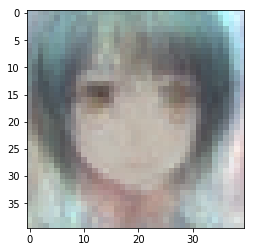

In [11]:
plt.imshow(vae1.predict(x_tr1[17].reshape([1, 4800])).reshape([40, 40, 3])*200)

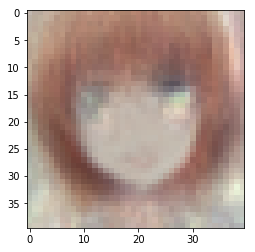

In [28]:
plt.imshow(vae1.predict(x_tr1[79].reshape([1, 4800])).reshape([40, 40, 3])*200)

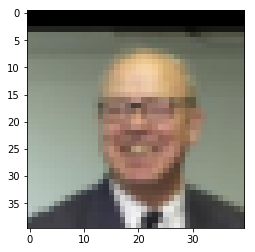

In [21]:
plt.imshow(x_tr2[38].reshape([40, 40, 3])*250)

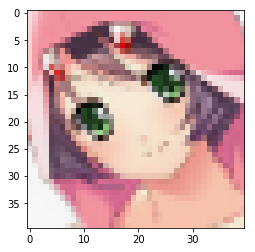

In [27]:
plt.imshow(x_tr1[79].reshape([40, 40, 3])*250)